In [187]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from itertools import product
import networkx as nx
from networkx.algorithms import community
import nxpd

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
plt.style.use('seaborn-dark-palette')
%matplotlib inline

In [280]:
# This block contains all the static information necessary for the risk game and creates the graph. 

# adjacent nodes, posits, territory, continent, continent color, card suit
g = {
    0: [[1,2,37],(1,13.2),'alaska','n_america','khaki','infantry'],
    1: [[0,2,6,12],(2.5,12.2),'northwest territory','n_america','khaki','cannon'],
    2: [[0,1,3,6],(2.4,10.9),'alberta','n_america','khaki','cavalry'],
    3: [[2,4,5,6],(2.6,9),'western united states','n_america','khaki','cannon'],
    4: [[3,5,7],(2.7,7),'central america','n_america','khaki','cannon'],
    5: [[3,4,6,11],(3.4,8.5),'eastern united states','n_america','khaki','cannon'],
    6: [[1,2,3,5,11,12],(3.4,10.7),'ontario','n_america','khaki','cavalry'],
    7: [[4,8,10],(3.8,5.6),'venezuela','s_america','darkorange','infantry'],
    8: [[7,9,10],(3.9,4),'peru','s_america','darkorange','infantry'],
    9: [[8,10],(4.1,1.8),'argentina','s_america','darkorange','infantry'],
    10: [[7,8,9,16],(4.8,4.2),'brazil','s_america','darkorange','cannon'],
    11: [[5,6,12],(4.4,10.5),'quebec','n_america','khaki','cavalry'],
    12: [[1,6,11,15],(5.2,12.4),'greenland','n_america','khaki','cavalry'],
    13: [[14,15,17,19],(6.1,9.6),'great britain','europe','cornflowerblue','cannon'],
    14: [[13,16,17,18],(6.4,7.5),'western europe','europe','cornflowerblue','cannon'],
    15: [[12,13,19],(6.2,11.3),'iceland','europe','cornflowerblue','infantry'],
    16: [[14,18,20,21,25],(7,5),'north africa','africa','saddlebrown','cavalry'],
    17: [[13,14,18,19,23],(7.2,9.1),'northern europe','europe','cornflowerblue','cannon'],
    18: [[14,16,17,20,23,24],(7.4,7.9),'southern europe', 'europe','cornflowerblue','cannon'],
    19: [[13,15,17,23],(7.5,11.5),'scandinavia','europe','cornflowerblue','cavalry'],
    20: [[16,18,24,25],(7.9,5.6),'egypt','africa','saddlebrown','infantry'],
    21: [[16,22,25],(7.8,3),'congo','africa','saddlebrown','infantry'],
    22: [[21,25,26],(8,1.1),'south africa','africa','saddlebrown','cannon'],
    23: [[17,18,19,24,27,28],(8.8,10),'ukraine','europe','cornflowerblue','cavalry'],
    24: [[18,20,23,25,27,29],(9,6),'middle east','asia','seagreen','infantry'],
    25: [[16,20,21,22,24,26],(8.5,3.8),'east africa','africa','saddlebrown','infantry'],
    26: [[22,25],(9.1,1.2),'madagascar','africa','saddlebrown','cavalry'],
    27: [[23,24,28,29,31],(9.8,8.6),'afghanistan','asia','seagreen','cavalry'],
    28: [[23,27,30,31],(10.1,11),'ural','asia','seagreen','cavalry'],
    29: [[24,27,31,36],(10.5,6.2),'india','asia','seagreen','cavalry'],
    30: [[28,31,32,33,34],(10.9,12),'siberia','asia','seagreen','cavalry'],
    31: [[27,28,29,30,33,36],(11.4,7.5),'china','asia','seagreen','infantry'],
    32: [[30,33,34,37],(11.7,10.8),'irkutsk','asia','seagreen','cavalry'],
    33: [[30,31,32,37,40],(11.9,9.1),'mongolia','asia','seagreen','infantry'],
    34: [[30,32,37],(11.9,12.5),'yakutsk','asia','seagreen','cavalry'],
    35: [[36,38,39],(11.9,3.1),'indonesia','australia','mediumvioletred','cannon'],
    36: [[29,31,35],(11.6,5.6),'siam','asia','seagreen','infantry'],
    37: [[0,32,33,34,40],(12.9,13.2),'kamchatka','asia','seagreen','infantry'],
    38: [[35,39,41],(12.4,1.2),'western australia','australia','mediumvioletred','cannon'],
    39: [[35,38,41],(13,3.9),'new guinea','australia','mediumvioletred','infantry'],
    40: [[33,37],(13.1,9),'japan','asia','seagreen','cannon'],
    41: [[38,39],(13.3,1.6),'eastern australia','australia','mediumvioletred','cannon']}

# create the graph
g_adj = {k : v[0] for k,v in g.items()}
G = nx.from_dict_of_lists(g_adj)

# makes straightforward dictionaries for easier code, faster, and plug into visualizations
val_eq_key = {k : k for k in g}
pos = {k : v[1] for k,v in g.items()}
territories = {k : v[2] for k,v in g.items()}
continents = {k : v[3] for k,v in g.items()}
colr = {k : v[4] for k,v in g.items()}
suit = {k : v[5] for k,v in g.items()}
degrees = {deg[0]:deg[1] for deg in G.degree}

# creates static dictionary of cards in deck (key is node, value is list with territory[0] and suit[1])
cards = {k : [v[2] , v[5]] for k,v in g.items()}
cards[42] = ['wild','wild']
cards[43] = ['wild','wild']

# create attribute dictionary
# key is node, value is list with normalized degree, cluster coefficient, and continent
norm_degree_list = [round(v/max(degrees.values()),3) for v in degrees.values()]
cluster_values = [round(v,3) for v in nx.clustering(G).values()]
vals = [[nd, cv] for nd,cv in zip(norm_degree_list,cluster_values)]
cluster_dict = dict(zip(range(42),vals))
att_dict = {k : cluster_dict[k] + [v] for k,v in continents.items()}

# nx.average_neighbor_degree(G) --- possible attribute to use instead of clustering coefficient

# creating country selection strategies
# takes a attribute dictionary, flattens it, sorts it, returns sorted nodes

# isolationist. minimizes degrees, maximizes cluster coefficient.
i0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[2], reverse=True)
i1 = sorted(i0, key=lambda x: x[1])
i2 = [x[0] for x in i1]

# network. maximizes degrees, minimizes cluster coefficient. 
n0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[2])
n1 = sorted(n0, key=lambda x: x[1], reverse=True)
n2 = [x[0] for x in n1]

# connecter. maximizes degrees, maximizes cluster coefficient.
c0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[2], reverse=True)
c1 = sorted(c0, key=lambda x: x[1], reverse=True)
c2 = [x[0] for x in c1]

# united states. focuses on n_america, tie goes to lower degree
u0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[1])
u1 = sorted([x[0:3] + [1] if x[3] == 'n_america' else x[0:3] + [0] for x in u0], key=lambda x: x[3], reverse=True)
u2 = [x[0] for x in u1]

# south america. focuses on s_america, tie goes to lower degree
s0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[1])
s1 = sorted([x[0:3] + [1] if x[3] == 's_america' else x[0:3] + [0] for x in s0], key=lambda x: x[3], reverse=True)
s2 = [x[0] for x in s1]

# pacific islands. focuses on australia, tie goes to lower degree
p0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[1])
p1 = sorted([x[0:3] + [1] if x[3] == 'australia' else x[0:3] + [0] for x in p0], key=lambda x: x[3], reverse=True)
p2 = [x[0] for x in p1]

# africa. focuses on africa, tie goes to lower degree
f0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[1])
f1 = sorted([x[0:3] + [1] if x[3] == 'africa' else x[0:3] + [0] for x in f0], key=lambda x: x[3], reverse=True)
f2 = [x[0] for x in f1]

# europe. focuses on europe, tie goes to lower degree
e0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[1])
e1 = sorted([x[0:3] + [1] if x[3] == 'europe' else x[0:3] + [0] for x in e0], key=lambda x: x[3], reverse=True)
e2 = [x[0] for x in e1]

# middle east. focuses on asia, tie goes to lower degree
m0 = sorted(([k]+v for k,v in att_dict.items()), key=lambda x: x[1])
m1 = sorted([x[0:3] + [1] if x[3] == 'asia' else x[0:3] + [0] for x in m0], key=lambda x: x[3], reverse=True)
m2 = [x[0] for x in m1]

In [189]:
# helper function for attrition(). created sorted lists of 6 sided dice rolls for comparison.
def roll_and_sort(dice):
    roll_list = []
    for _ in range(dice):
        roll_list.append(np.random.randint(1,7))
    roll_list.sort(reverse=True)
    return roll_list

In [190]:
# work horse of the project. simulates combat with the dice rolled decreasing as troop numbers fall.
def attrition(attackers, defenders):
    while attackers >= 1 and defenders >= 1:
        att_list = roll_and_sort(min([3,attackers]))
        def_list = roll_and_sort(min([2,defenders]))
        if attackers >= 2 and defenders >= 2:
            if att_list[1] > def_list[1]:
                defenders -= 1
            else: attackers -= 1
        if att_list[0] > def_list[0]:
            defenders -= 1
        else: attackers -= 1
    return attackers, defenders

In [191]:
# returns a list of nodes with continent keys
def continents2():
    cont_d = {}
    continent_list = ['n_america','s_america','europe','africa','asia','australia']
    for c in continent_list:
        cont_d[c] = [k for k,v in g.items() if v[3] == c]
    return cont_d

In [192]:
# dictionary of the node and current troops at that node
def current_troops():
    return {x[0] : x[1]['troops'] for x in G.nodes.data()}
# changes the troop count to an X for each troop
def x_current_troops():
    return {k : 'X'*v for k,v in current_troops().items()}
# creates a list proportional to troop size to plug into node size on the visualization
def ns_troop_var():
    return [150*v for v in current_troops().values()]

In [193]:
# used only to color the continents on the reference graph
def player_colors():
    color_list = []
    for p in G.nodes.data():
        if p[1]['player'][2] == '1': dot_color = 'lightskyblue'
        elif p[1]['player'][2] == '2': dot_color = 'red'
        elif p[1]['player'][2] == '3': dot_color = 'lightgreen'
        elif p[1]['player'][2] == '4': dot_color = 'gray'
        elif p[1]['player'][2] == '5': dot_color = 'yellow'
        elif p[1]['player'][2] == '6': dot_color = 'pink'
        color_list.append(dot_color)
    return color_list

1 is blue, 2 is red, 3 is green, 4 is grey, 5 is yellow, 6 is pink

In [194]:
# plots a graph of the current status of the game with node size proportional to troops placed there
# used to verify functions are working at each stage in the game
def plot_game_graph():
    plt.style.use('seaborn-white')
    plt.figure(figsize=(14,9))
    nx.draw_networkx(G, pos, node_size=ns_troop_var(), node_color=player_colors(), edge_color='dimgrey', \
                     style='dotted', labels=current_troops(), font_size=10, font_weight='bold')

In [195]:
# reference graph to verify connecting nodes and continents visually
def plot_node_graph():
    plt.style.use('seaborn-white')
    plt.figure(figsize=(14,9))
    nx.draw_networkx(G, pos, node_color=colr.values(), edge_color='dimgrey', style='dotted', labels=val_eq_key, \
                     font_size=10, font_weight='bold')

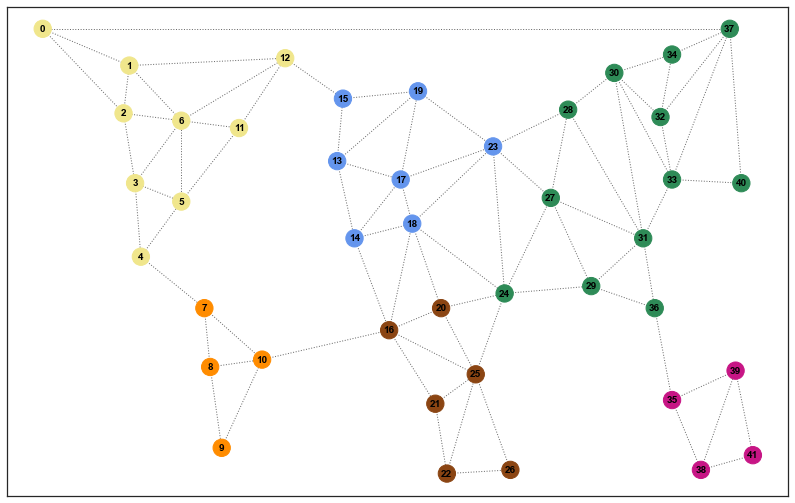

In [281]:
# makes a basic plot. basic plot shows the node numbering and is colored by continent
plot_node_graph()

# START OF GAME FUNCTIONS

## 1.roll die to see who starts

In [196]:
# picks a random player to start the game
def roll_for_turn(players):
    return np.random.choice(len(players))

# creates a repeating list of the players
def generate_turns(players):
    return players * 1000

## 2.select territories

In [291]:
# selects territories for each player based on that player's strategy
def select_territories(turn, turns):
    available_territories = list(range(42))
    for x in range(42): 
        G.nodes[x]['player'] = ''
        G.nodes[x]['troops'] = 0
    for p in turns[turn:42+turn]:
        if p[0] == 'r':
            num = np.random.choice(available_territories)
        if p[0] == 'i':
            num = [x for x in i2 if x in available_territories][0]
        if p[0] == 'n':
            num = [x for x in n2 if x in available_territories][0]
        if p[0] == 'c':
            num = [x for x in c2 if x in available_territories][0]
            if friend_nodes(p):
                cnodes = set([item for sublist in [[n for n in g_adj[f]] for f in friend_nodes(p)] \
                              for item in sublist])
                possibles = [x for x in [c for c in cnodes if c not in friend_nodes(p)] \
                       if x in available_territories]
                if possibles:
                    num = possibles[0]
        if p[0] == 'u':
            num = [x for x in u2 if x in available_territories][0]
        if p[0] == 's':
            num = [x for x in s2 if x in available_territories][0]
        if p[0] == 'p':
            num = [x for x in p2 if x in available_territories][0]
        if p[0] == 'f':
            num = [x for x in f2 if x in available_territories][0]
        if p[0] == 'e':
            num = [x for x in e2 if x in available_territories][0]
        if p[0] == 'm':
            num = [x for x in m2 if x in available_territories][0]
    
        G.nodes[num]['player'] = p
        G.nodes[num]['troops'] = 1
        available_territories.remove(num)

## 3.place troops

In [198]:
# friend_army returns node and troops for the player whose turn it is (list of lists)
def friend_army(player):
    return [[num, G.nodes[num]['troops']] for num in range(42) if G.nodes[num]['player'] == player]

# enemy_army returns node and troops for all other players (list of lists)
def enemy_army(player):
    return [[num, G.nodes[num]['troops']] for num in range(42) if G.nodes[num]['player'] != player]

# friend_nodes returns node list for the player whose turn it is (list)
def friend_nodes(player):
    return [num for num in range(42) if G.nodes[num]['player'] == player]

# enemy_nodes returns node list for all other players (list)
def enemy_nodes(player):
    return [num for num in range(42) if G.nodes[num]['player'] != player]

In [199]:
# returns friendly node, friendly defenders, potential enemy attackers as list of lists
def def_troop_comparison(player):
    enemy_troops = []
    poten_attackers = []
    for f in friend_nodes(player):
        for n in g_adj[f]:
            if n in enemy_nodes(player):
                enemy_troops.append(G.nodes[n]['troops'] - 1)
            else: continue
        poten_attackers.append(sum(enemy_troops))
        enemy_troops = []
    
    return [friend_army(player)[idx] + [v] for idx,v in enumerate(poten_attackers)]

In [200]:
# returns enemy node, enemy defenders, potential friendly attackers as list of lists
def off_troop_comparison(player):
    friendly_troops = []
    poten_attackers = []
    for e in enemy_nodes(player):
        for n in g_adj[e]:
            if n in friend_nodes(player):
                friendly_troops.append(G.nodes[n]['troops'] - 1)
            else: continue
        poten_attackers.append(sum(friendly_troops))
        friendly_troops = []
    
    return [enemy_army(player)[idx] + [v] for idx,v in enumerate(poten_attackers)]

In [201]:
# places troops for each player based on other players buildups and each player's strategy.
def place_troops(players, turn, turns):
    if len(players) == 2: extra_troops = 50
    if len(players) == 3: extra_troops = 35
    if len(players) == 4: extra_troops = 30
    if len(players) == 5: extra_troops = 25
    if len(players) == 6: extra_troops = 20
    
    for p in turns[turn + 42 : turn + len(players) * extra_troops]:
        if p[1] == 'r':
#             randomly selects from friendly territories
            num = np.random.choice(friend_nodes(p))
        if p[1] == 'd':
#             randomly selects from most vulnerable nodes: (potential att - def)/(potential att + def)
            vuln_list = [[x[0]] + [round((x[2] - x[1]) / (x[2] + x[1]),3)] for x in def_troop_comparison(p)]
            s_vuln_list = sorted(vuln_list, key=lambda x: x[1], reverse=True)
            most_vuln = [x[0] for x in s_vuln_list if x[1] == max(x[1] for x in s_vuln_list)]
            if len(most_vuln) > 0:
                num = np.random.choice(most_vuln)
            else: num = np.random.choice(friend_nodes(p))
        if p[1] == 'a':           
#             randomly selects friendly node with least troops adj to most vulnerable enemy territory
            e_vuln_list = [[x[0]] + [round((x[2] - x[1]) / (x[2] + x[1]),3)] for x in off_troop_comparison(p)]
            s_e_vuln_list = sorted(e_vuln_list, key=lambda x: x[1], reverse=True)
            e_most_vuln = [x[0] for x in s_e_vuln_list if x[1] == max(x[1] for x in s_e_vuln_list)]
            nodes_sur_e_vuln = set([item for sublist in [g_adj[x] for x in e_most_vuln] for item in sublist])
            f_sup_nodes = [x for x in nodes_sur_e_vuln if x in friend_nodes(p)]
            s_f_sup_nodes = sorted([[x[0]] + [x[1]['troops']] for x in G.nodes.data() if x[0] in f_sup_nodes], \
                                   key=lambda x: x[1])
            best_att_sup = [x[0] for x in s_f_sup_nodes if x[1] == min(x[1] for x in s_f_sup_nodes)]
            if len(best_att_sup) > 0:
                num = np.random.choice(best_att_sup)
            else: num = np.random.choice(friend_nodes(p))
        
        G.nodes[num]['troops'] += 1

## 4.play

while len([G.nodes[num]['player'] for num in range(42) if G.nodes[num]['player'] == turns[turn]]) < 42:

## player turn

In [202]:
# verify they have territories, if not, skip
def check_defeat(player):
    return len([G.nodes[num]['player'] for num in range(42) if G.nodes[num]['player'] == player]) < 1

## calculate troops from territories, continents, cards

In [203]:
def extra_troops(player):
    return max([3,len([G.nodes[num]['player'] for num in range(42) if G.nodes[num]['player'] == player])//3])

In [204]:
# define continents with territories
def continent_bonus(player):
#     continent_list = ['n_america','s_america','europe','africa','asia','australia']
    bonus = 0
    for k,v in continents2().items():
        match_lst = [n for n in v if n in friend_nodes(player)]
        if match_lst == v:
            if k == 'n_america': bonus += 5
            if k == 's_america': bonus += 2
            if k == 'africa': bonus += 3
            if k == 'asia': bonus += 7
            if k == 'europe': bonus += 5
            if k == 'australia': bonus += 2
    return bonus

## draw card at end of turn if player won territory

draw card (random draw, no replacement)<br>
store card with player<br>
if player has 3 cannons, 3 infantry, 3 cavalry, or 1 of each<br>
exchange cards (deduct cards, add troops)<br>
if player conquers another player, take defeated players cards<br>
reshuffle deck with all the cards not in players hands if the deck runs out

In [205]:
# takes in past exchanges and returns the number of troops received for the next exchange
def card_value(exchange):
    if exchange <= 5:
        return 2 * (exchange+1)
    else:
        return 5 * (exchange-3)
    
# If card exchanged where the player owns that territory they get an extra 2 in that territory (max 1 x per exchange)

In [206]:
# shuffles a full deck and sets players hands to empty
def shuffle(players):
    deck = list(range(44))
    hands = {}
    for p in players:
        hands[p] = []
    return deck, hands

In [207]:
# if the deck runs out, reshuffles remaining cards
def shuf(hands):
    cards_in_hands = set([item for sublist in [hands[hand] for hand in hands] for item in sublist])
    deck = list(range(44))
    if len(cards_in_hands):
        for c in cards_in_hands:
            deck.remove(c)
    return deck

In [258]:
# draws card and puts it in the players hand; removes it from deck
def draw_card(player, deck, hands):
    if len(deck) == 0:
        deck = shuf(hands)
    draw = np.random.choice(deck)
    deck.remove(draw)
    hands[player] = hands[player] + [draw]
    return deck

In [209]:
# checks hand for sets, deduct sets, increments exchanges; returns bonus troops
def exch_cards(player, next_exch, hands):
    wilds = len([cards[c][1] for c in hands[player] if cards[c][1] == 'wild'])
    infantries = len([cards[c][1] for c in hands[player] if cards[c][1] == 'infantry']) + wilds
    cavalries = len([cards[c][1] for c in hands[player] if cards[c][1] == 'cavalry']) + wilds
    cannons = len([cards[c][1] for c in hands[player] if cards[c][1] == 'cannon']) + wilds
    bonus = 0

    if infantries > 2:
        bonus += card_value(next_exch)
        next_exch += 1
        for r in range(3-wilds):
            hands[player].remove([c for c in hands[player] if cards[c][1] == 'infantry'][0])
            infantries -= 1
            if wilds > 0:
                for r in range(wilds):
                    hands[player].remove([c for c in hands[player] if cards[c][1] == 'wild'][0])
                    wilds -= 1
                    infantries -= 1
                    cavalries -= 1
                    cannons -= 1

    if cavalries > 2:
        bonus += card_value(next_exch)
        next_exch += 1
        for r in range(3-wilds):
            hands[player].remove([c for c in hands[player] if cards[c][1] == 'cavalry'][0])
            cavalries -= 1
            if wilds > 0:
                for r in range(wilds):
                    hands[player].remove([c for c in hands[player] if cards[c][1] == 'wild'][0])
                    wilds -= 1
                    infantries -= 1
                    cavalries -= 1
                    cannons -= 1
                
    if cannons > 2:
        bonus += card_value(next_exch)
        next_exch += 1
        for r in range(3-wilds):
            hands[player].remove([c for c in hands[player] if cards[c][1] == 'cannon'][0])
            cannons -= 1
            if wilds > 0:
                for r in range(wilds):
                    hands[player].remove([c for c in hands[player] if cards[c][1] == 'wild'][0])
                    wilds -= 1
                    infantries -= 1
                    cavalries -= 1
                    cannons -= 1

    if (infantries > 0 and cavalries > 0 and cannons > 0 and wilds==0):
        bonus += card_value(next_exch)
        next_exch += 1
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'infantry'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'cavalry'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'cannon'][0])
        infantries -= 1
        cavalries -= 1
        cannons -= 1

    if (infantries > 0 and cavalries > 1 and cannons > 1 and wilds==1):
        bonus += card_value(next_exch)
        next_exch += 1
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'wild'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'cavalry'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'cannon'][0])
        wilds -= 1
        infantries -= 1
        cavalries -= 2
        cannons -= 2
    
    if (infantries > 1 and cavalries > 0 and cannons > 1 and wilds==1):
        bonus += card_value(next_exch)
        next_exch += 1
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'wild'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'infantry'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'cannon'][0])
        wilds -= 1
        infantries -= 2
        cavalries -= 1
        cannons -= 2
    
    if (infantries > 1 and cavalries > 1 and cannons > 0 and wilds==1):
        bonus += card_value(next_exch)
        next_exch += 1
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'wild'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'infantry'][0])
        hands[player].remove([c for c in hands[player] if cards[c][1] == 'cavalry'][0])
        wilds -= 1
        infantries -= 2
        cavalries -= 2
        cannons -= 1

    return (bonus, next_exch)

## reinforcements

In [246]:
# takes in the player and reinforcements and places those reinforcements based on the player's strategy
def place_reinforcements(player, reinforcements):    
    for troop in range(reinforcements):
        if player[1] == 'r':
#           randomly selects from friendly territories that border on enemy territories
            near_border = set([item for sublist in [g_adj[x] for x in enemy_nodes(player)] for item in sublist])
            adj_to_enemy = [x for x in near_border if x in friend_nodes(player)]
            num = np.random.choice(adj_to_enemy)
        if player[1] == 'd':
#           randomly selects from most vulnerable nodes: (potential att - def)/(potential att + def)
            vuln_list = [[x[0]] + [round((x[2] - x[1]) / (x[2] + x[1]),3)] for x in def_troop_comparison(player)]
            s_vuln_list = sorted(vuln_list, key=lambda x: x[1], reverse=True)
            most_vuln = [x[0] for x in s_vuln_list if x[1] == max(x[1] for x in s_vuln_list)]
            if len(most_vuln) > 0:
                num = np.random.choice(most_vuln)
            else: num = np.random.choice(friend_nodes(player))
        if player[1] == 'a':           
#           randomly selects friendly node with least troops adj to most vulnerable enemy territory
            e_vuln_list = [[x[0]] + [round((x[2] - x[1]) / (x[2] + x[1]),3)] for x in off_troop_comparison(player)]
            s_e_vuln_list = sorted(e_vuln_list, key=lambda x: x[1], reverse=True)
            e_most_vuln = [x[0] for x in s_e_vuln_list if x[1] == max(x[1] for x in s_e_vuln_list)]
            nodes_sur_e_vuln = set([item for sublist in [g_adj[x] for x in e_most_vuln] for item in sublist])
            f_sup_nodes = [x for x in nodes_sur_e_vuln if x in friend_nodes(player)]
            s_f_sup_nodes = sorted([[x[0]] + [x[1]['troops']] for x in G.nodes.data() if x[0] in f_sup_nodes], \
                                   key=lambda x: x[1])
            best_att_sup = [x[0] for x in s_f_sup_nodes if x[1] == min(x[1] for x in s_f_sup_nodes)]
            if len(best_att_sup) > 0:
                num = np.random.choice(best_att_sup)
            else: num = np.random.choice(friend_nodes(player))
        
        G.nodes[num]['troops'] += 1

## attack

In [211]:
# helper function finding the neighbor nodes that are adjacent to the node listed and friendly to the player listed
def sur_f_nodes(player, node):
    sur_nodes = set([item for sublist in [g_adj[x] for x in [node]] for item in sublist])
    return [x for x in sur_nodes if x in friend_nodes(player)]

In [212]:
# helper function finding the neighbor nodes that are adjacent to the node listed and enemies to the player listed
def sur_e_nodes(player, node):
    sur_nodes = set([item for sublist in [g_adj[x] for x in [node]] for item in sublist])
    return [x for x in sur_nodes if x in enemy_nodes(player)]

In [213]:
# simulates an attack phase for a player that attacks when they outnumber the defender.
def attack(player, hands):
    e_vuln_list = [[x[0]] + [round((x[2] - x[1]) / (x[2] + x[1]),3)] for x in off_troop_comparison(player)]
    s_e_vuln_list = sorted(e_vuln_list, key=lambda x: x[1], reverse=True)
    
    for x in range(len(e_vuln_list)):
        if len(s_e_vuln_list) > 0:
            if s_e_vuln_list[0][1] >= 0:
#               s_e_vuln_list[0][0] is the enemy node (int) that is worth attacking (you outnumber the enemy)
                under_attack = s_e_vuln_list[0][0]
                def_troops = G.nodes.data()[under_attack]['troops']
#               attacking is a list of the surrounding friendly nodes
                attacking = sur_f_nodes(player, under_attack)
#               sorts attacking by the number of connected enemy nodes, least to greatest
                s_attacking = [a[0] for a in sorted([[a, len(sur_e_nodes(player,a))] for a in attacking], \
                                                    key=lambda x: x[1])]
                att_force = 0
                for a in s_attacking:
#                   if the node under attack is their only enemy neighbor, attack with everything
                    if len(sur_e_nodes(player, a)) == 1:
                        att_force += G.nodes[a]['troops'] - 1
                        G.nodes[a]['troops'] = 1
#                   if the node under attack is 1 of a few enemy neighbor, attack with enough to probably win
                    else: 
                        for trps in range(G.nodes[a]['troops']-1):
                            if att_force <= def_troops:
                                G.nodes[a]['troops'] -= 1
                                att_force += 1
#               this is where the fighting happens!
                a_surv, d_surv = attrition(att_force, def_troops)
                if a_surv == 0:
                    G.nodes[under_attack]['troops'] = d_surv
                else:
#                   defeated players cards go to their conqueror if that's their last territory
                    if len([G.nodes[n]['player'] for n in range(42) if G.nodes[n]['player'] == \
                            G.nodes[under_attack]['player']]) == 1:
                        hands[player] = hands[player] + hands[G.nodes[under_attack]['player']]
                        hands[G.nodes[under_attack]['player']] = []
                    G.nodes[under_attack]['player'] = player
                    G.nodes[under_attack]['troops'] = a_surv
                s_e_vuln_list.remove(s_e_vuln_list[0])

## draw card if territories increase that round

checks to see if their territories increased after their attacks and they draw a card if they did.<br>

territories_bef_att = len([G.nodes[num]['player'] for num in range(42) if G.nodes[num]['player'] == turns[turn]]<br>
attack(turns[turn])<br>
territories_aft_att = len([G.nodes[num]['player'] for num in range(42) if G.nodes[num]['player'] == turns[turn]]<br>
if territories_bef_att < territories_aft_att: draw_card(turns[turn], deck)

## move troops

## end turn

## 5.record winner with turns and troop total

# END OF STEPPING THROUGH THE GAME FUNCTIONS

# GAME CLASS

In [538]:
class Game():
    
    def __init__(self, players):
        self.players = players
        self.test_player = players[0]
        self.deck, self.hands = shuffle(players)
        self.next_exch = 1
        self.turn = roll_for_turn(players)
        self.turns = generate_turns(players)
        select_territories(self.turn, self.turns)
        place_troops(self.players, self.turn, self.turns)
#         plot_game_graph()
    
    def play(self):
        while len([G.nodes[n]['player'] for n in range(42) if G.nodes[n]['player'] == self.turns[self.turn]]) < 42:
            if check_defeat(self.turns[self.turn]):
#                 if self.turns[self.turn] == self.test_player:
                    #the test_player has lost, zero for loss
#                     return ([0, self.turn])
                self.turn+=1
                continue
#             print(f"{self.turns[self.turn]}: {len([G.nodes[n]['player'] for n in range(42) if G.nodes[n]['player'] == self.turns[self.turn]])}")
#             plot_game_graph()
            territory_bonus = extra_troops(self.turns[self.turn]) + continent_bonus(self.turns[self.turn])
            card_bonus, self.next_exch = exch_cards(self.turns[self.turn], self.next_exch, self.hands)
            reinforcements = territory_bonus + card_bonus
#             plot_game_graph()
            place_reinforcements(self.turns[self.turn], reinforcements)
            territories_bef_att = len([G.nodes[n]['player'] for n in range(42) if G.nodes[n]['player'] == self.turns[self.turn]])
            attack(self.turns[self.turn], self.hands)
            territories_aft_att = len([G.nodes[n]['player'] for n in range(42) if G.nodes[n]['player'] == self.turns[self.turn]])
            if territories_bef_att < territories_aft_att: 
                self.deck = draw_card(self.turns[self.turn], self.deck, self.hands)
            self.turn += 1
#             plot_game_graph()

# data to return: winner, turn number          
#         return ([1, self.turn]) 

# for tournaments return winner as string
#         return self.turns[self.turn]    
    
        print(f'winner {self.turns[self.turn]}')
        print(f'turn   {self.turn}')
        print(f'deck   {self.deck}')
        print(f'hands  {self.hands}')
        print(f'sets exchanged  {self.next_exch-1}')

game1= Game(['fr1','ir2','pr3','sr4','ur5'])
game1.next_exch
game1.play()


'id2'

### Player Type Key
territory selection: 'r' random, 'i' isolationist, 'n' network, 'c' connecter, 'u' united states, 's' south america, 'p' pacific islands, 'f' africa, 'e' europe, 'm' middle east<br>
play style: 'r' random,'a' aggressive, 'd' defensive

In [295]:
# generates a list of random players out of 30 different play styles
def rando(num_pl):
    ter_sel = ['r','i','n','c','u','s','p','f','e','m']
    pl_styl = ['r','a','d']
    player_list = []
    for p in range(1,num_pl+1):
        t = np.random.choice(ter_sel)
        s = np.random.choice(pl_styl)
        profile = t+s+str(p)
        player_list.append(profile)
    return player_list

In [302]:
# creates a list of strings containing all the permutations of player strategies available
def create_test_players():
    ter_sel = ['r','i','n','c','u','s','p','f','e','m']
    pl_styl = ['r','a','d']
    player_list = []
    for t in ter_sel:
        for s in pl_styl:
            profile = t+s+str(1)
            player_list.append(profile)
    return player_list

In [526]:
# simulates multiple games. the parameters are: # of games and what player strategy to test against random strategies
def play_multiple_games(num, test_player):
    all_games_data = []
    i = 0
    while i < num:
        game = Game([test_player] + rando(5)[1:])
        print(f'Our players: {game.players}')
        game_data_list = game.play()
        all_games_data.append(game_data_list)
        i+=1
    
    return all_games_data

play_multiple_games(2, 'cd1')
play_multiple_games(2, 'na1')

Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']


[{'fr1'}, {'sr4'}]

In [308]:
# takes in a list of strings as player strategies to test and the number of tests on each of those strategies
# returns a dictionary of player strategies with a list of list of whether they won and the turn they won, or lost at
def create_data_dict(test_players, num_tests):
    data_dict = {}
    for test_player in test_players:
        data = play_multiple_games(num_tests, test_player)
        data_dict[test_player] = data
    
    # data_dict will have test_player as key and list of data of games as value- {'cd1': [[0, 50], [0, 40]]}
    return data_dict

In [ ]:
contenders = ['fr1','ir2','pr3','sr4','ur5']

# makes a list of strings of the winner of each game
def tournament(num, contenders):
    all_games_data = []
    i = 0
    while i < num:
        game = Game(contenders)
        print(f'Our players: {game.players}')
        game_data_list = game.play()
        all_games_data.append(game_data_list)
        i+=1
    
    return all_games_data

# DATA GATHERING AND EXPLORATION

In [553]:
# Played 1000 games with these 5, but didn't save string so this block won't run with new kernal
print(f"africa {round(tournament_list.count('fr1')/1000,3)}")
print(f"isolationist {round(tournament_list.count('ir2')/1000,3)}")
print(f"pacific islands {round(tournament_list.count('pr3')/1000,3)}")
print(f"south america {round(tournament_list.count('sr4')/1000,3)}")
print(f"united states {round(tournament_list.count('ur5')/1000,3)}")

africa 0.334
isolationist 0.038
pacific islands 0.212
south america 0.283
united states 0.133


In [566]:
# used to create original dataframe. no longer necessary.
data_dict_list = [data_dict_rr,data_dict_ra,data_dict_rd,data_dict_ir,data_dict_ia,data_dict_id,data_dict_nr,\
                  data_dict_na,data_dict_nd,data_dict_cr,data_dict_ca,data_dict_cd,data_dict_ur,data_dict_ua,\
                  data_dict_ud,data_dict_sr,data_dict_sa,data_dict_sd,data_dict_pr,data_dict_pa,data_dict_pd,\
                  data_dict_fr,data_dict_fa,data_dict_fd,data_dict_er,data_dict_ea,data_dict_ed,data_dict_mr,\
                  data_dict_ma,data_dict_md]
behavior_list = ['rr','ra','rd','ir','ia','id','nr','na','nd','cr','ca','cd','ur','ua','ud','sr','sa','sd',\
                 'pr','pa','pd','fr','fa','fd','er','ea','ed','mr','ma','md']

for ddl, b in zip(data_dict_list, behavior_list):
    if ddl == data_dict_rr:
        df = pd.DataFrame({x : [y[0] for y in ddl[x]] for x in ddl})
        df['rr_turns'] = pd.DataFrame({x : [y[1] for y in ddl[x]] for x in ddl})
    else:
        df[str(b) + '1'] = pd.DataFrame({x : [y[0] for y in ddl[x]] for x in ddl})
        df[str(b) + '_turns'] = pd.DataFrame({x : [y[1] for y in ddl[x]] for x in ddl})


In [524]:
# gets summary stats for aggregated behaviors
# bt: choose 0 or 1 for territory selection or troop placement
# char: choose the char as a string for the behavior to analyze
def rdl(num, length, d):
    return round(num / length, d)

def group_avg(bt,char):
    l = 0
    run_sum = 0
    run_sum_wt = 0
    run_sum_wt_std = 0
    run_sum_lt = 0
    run_sum_lt_std = 0

    for b in behavior_list:
        if b[bt] == char:
            l += 1
            run_sum += df[f'{b}1'].mean()
            run_sum_wt += df[df[f'{b}1'] == 1][f'{b}_turns'].mean()
            run_sum_wt_std += df[df[f'{b}1'] == 1][f'{b}_turns'].std()
            run_sum_lt += df[df[f'{b}1'] == 0][f'{b}_turns'].mean()
            run_sum_lt_std += df[df[f'{b}1'] == 0][f'{b}_turns'].std()
            
    return rdl(run_sum,l,2),rdl(run_sum_wt,l,0),rdl(run_sum_wt_std,l,0),rdl(run_sum_lt,l,0),rdl(run_sum_lt_std,l,0)

group_avg(0,'m')

(0.13, 267.0, 237.0, 92.0, 99.0)

In [486]:
# creates summary statistics for combined behaviors
for b in behavior_list:
    print(f"{b} win per: {df[f'{b}1'].mean()}")
    print(f"{b} w turns: {round(df[df[f'{b}1'] == 1][f'{b}_turns'].mean())}")
    print(f"{b} w t std: {round(df[df[f'{b}1'] == 1][f'{b}_turns'].std())}")
    print(f"{b} l turns: {round(df[df[f'{b}1'] == 0][f'{b}_turns'].mean())}")
    print(f"{b} l t std: {round(df[df[f'{b}1'] == 0][f'{b}_turns'].std())}\n")

rr win per: 0.19
rr w turns: 173
rr w t std: 124
rr l turns: 129
rr l t std: 290

ra win per: 0.09
ra w turns: 514
ra w t std: 326
ra l turns: 134
ra l t std: 151

rd win per: 0.15
rd w turns: 210
rd w t std: 88
rd l turns: 79
rd l t std: 77

ir win per: 0.48
ir w turns: 123
ir w t std: 72
ir l turns: 106
ir l t std: 86

ia win per: 0.16
ia w turns: 461
ia w t std: 468
ia l turns: 179
ia l t std: 232

id win per: 0.2
id w turns: 196
id w t std: 111
id l turns: 101
id l t std: 69

nr win per: 0.18
nr w turns: 205
nr w t std: 126
nr l turns: 107
nr l t std: 188

na win per: 0.07
na w turns: 594
na w t std: 822
na l turns: 87
na l t std: 84

nd win per: 0.06
nd w turns: 252
nd w t std: 121
nd l turns: 67
nd l t std: 78

cr win per: 0.2
cr w turns: 143
cr w t std: 76
cr l turns: 95
cr l t std: 149

ca win per: 0.04
ca w turns: 324
ca w t std: 237
ca l turns: 124
ca l t std: 125

cd win per: 0.13
cd w turns: 190
cd w t std: 62
cd l turns: 70
cd l t std: 57

ur win per: 0.4
ur w turns: 111
u

rr,ca,id,ur,nd,pd,ud,ua,pr,pa,fr,sr,er,ir,nr,cr,mr,ra,ia,na,sa,fa,ea,ma,rd,cd,sd,fd,ed,md

In [541]:
tournament_list = tournament(1000, contenders)

Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1', 'ir2', 'pr3', 'sr4', 'ur5']
Our players: ['fr1',

In [430]:
data_dict_md = create_data_dict(['md1'], 100)

Our players: ['md1', 'ra2', 'ma3', 'ma4', 'ua5']
Our players: ['md1', 'fr2', 'nd3', 'fr4', 'er5']
Our players: ['md1', 'pr2', 'sd3', 'ed4', 'pr5']
Our players: ['md1', 'fd2', 'mr3', 'nd4', 'nd5']
Our players: ['md1', 'rr2', 'cr3', 'mr4', 'id5']
Our players: ['md1', 'sr2', 'pd3', 'ir4', 'ma5']
Our players: ['md1', 'ca2', 'sa3', 'er4', 'pr5']
Our players: ['md1', 'ma2', 'ir3', 'sa4', 'rr5']
Our players: ['md1', 'ua2', 'na3', 'rd4', 'ur5']
Our players: ['md1', 'pr2', 'id3', 'rd4', 'nr5']
Our players: ['md1', 'id2', 'pd3', 'ia4', 'fr5']
Our players: ['md1', 'nd2', 'cr3', 'ma4', 'pd5']
Our players: ['md1', 'sr2', 'fd3', 'er4', 'nd5']
Our players: ['md1', 'sa2', 'ir3', 'ed4', 'ea5']
Our players: ['md1', 'ua2', 'ud3', 'ud4', 'ed5']
Our players: ['md1', 'pa2', 'ur3', 'nd4', 'nr5']
Our players: ['md1', 'ir2', 'ia3', 'rd4', 'er5']
Our players: ['md1', 'sr2', 'pa3', 'cr4', 'sd5']
Our players: ['md1', 'ur2', 'er3', 'md4', 'ca5']
Our players: ['md1', 'cd2', 'ur3', 'ca4', 'cd5']
Our players: ['md1',

In [429]:
data_dict_ed = create_data_dict(['ed1'], 100)

Our players: ['ed1', 'ea2', 'ur3', 'id4', 'ua5']
Our players: ['ed1', 'sa2', 'pr3', 'ra4', 'ia5']
Our players: ['ed1', 'ed2', 'fa3', 'nr4', 'na5']
Our players: ['ed1', 'ca2', 'er3', 'pa4', 'sd5']
Our players: ['ed1', 'ud2', 'sd3', 'sa4', 'pd5']
Our players: ['ed1', 'ma2', 'ma3', 'ma4', 'ra5']
Our players: ['ed1', 'ir2', 'id3', 'ir4', 'ea5']
Our players: ['ed1', 'rr2', 'ir3', 'md4', 'ed5']
Our players: ['ed1', 'er2', 'fa3', 'md4', 'md5']
Our players: ['ed1', 'nr2', 'nr3', 'cd4', 'rd5']
Our players: ['ed1', 'cr2', 'rr3', 'id4', 'sa5']
Our players: ['ed1', 'sr2', 'ca3', 'md4', 'na5']
Our players: ['ed1', 'mr2', 'ed3', 'cr4', 'ur5']
Our players: ['ed1', 'fr2', 'sd3', 'sa4', 'er5']
Our players: ['ed1', 'mr2', 'ra3', 'fd4', 'rd5']
Our players: ['ed1', 'id2', 'er3', 'cr4', 'rd5']
Our players: ['ed1', 'ud2', 'ea3', 'ua4', 'ra5']
Our players: ['ed1', 'md2', 'fa3', 'rr4', 'pa5']
Our players: ['ed1', 'ir2', 'ra3', 'fa4', 'ra5']
Our players: ['ed1', 'sr2', 'na3', 'rr4', 'pd5']
Our players: ['ed1',

In [428]:
data_dict_fd = create_data_dict(['fd1'], 100)

Our players: ['fd1', 'rd2', 'ir3', 'sr4', 'id5']
Our players: ['fd1', 'ua2', 'rr3', 'ea4', 'nd5']
Our players: ['fd1', 'er2', 'ed3', 'fa4', 'ia5']
Our players: ['fd1', 'md2', 'ra3', 'nd4', 'ma5']
Our players: ['fd1', 'cr2', 'ea3', 'ed4', 'pr5']
Our players: ['fd1', 'ir2', 'ud3', 'na4', 'sa5']
Our players: ['fd1', 'ed2', 'nd3', 'sr4', 'ur5']
Our players: ['fd1', 'pd2', 'er3', 'cd4', 'fr5']
Our players: ['fd1', 'ea2', 'rr3', 'ur4', 'ea5']
Our players: ['fd1', 'sa2', 'rr3', 'ea4', 'ea5']
Our players: ['fd1', 'ea2', 'ed3', 'ra4', 'sd5']
Our players: ['fd1', 'ur2', 'ma3', 'ia4', 'ra5']
Our players: ['fd1', 'cd2', 'ur3', 'rd4', 'ra5']
Our players: ['fd1', 'pd2', 'ra3', 'cd4', 'rd5']
Our players: ['fd1', 'ud2', 'ma3', 'ur4', 'ur5']
Our players: ['fd1', 'sa2', 'na3', 'na4', 'sd5']
Our players: ['fd1', 'pa2', 'rd3', 'nr4', 'md5']
Our players: ['fd1', 'rd2', 'ca3', 'pa4', 'er5']
Our players: ['fd1', 'fd2', 'ur3', 'sr4', 'mr5']
Our players: ['fd1', 'ca2', 'nd3', 'fa4', 'ma5']
Our players: ['fd1',

In [427]:
data_dict_sd = create_data_dict(['sd1'], 100)

Our players: ['sd1', 'mr2', 'ud3', 'pr4', 'er5']
Our players: ['sd1', 'ma2', 'cd3', 'pa4', 'rd5']
Our players: ['sd1', 'fr2', 'md3', 'id4', 'nd5']
Our players: ['sd1', 'ca2', 'nd3', 'fr4', 'pd5']
Our players: ['sd1', 'fr2', 'sd3', 'md4', 'sd5']
Our players: ['sd1', 'sr2', 'mr3', 'cd4', 'ma5']
Our players: ['sd1', 'pa2', 'ma3', 'ca4', 'mr5']
Our players: ['sd1', 'fa2', 'cd3', 'nd4', 'fa5']
Our players: ['sd1', 'ia2', 'pr3', 'ia4', 'pr5']
Our players: ['sd1', 'pd2', 'nd3', 'fd4', 'cr5']
Our players: ['sd1', 'fd2', 'pa3', 'na4', 'id5']
Our players: ['sd1', 'ma2', 'rd3', 'mr4', 'ir5']
Our players: ['sd1', 'ea2', 'ca3', 'ca4', 'id5']
Our players: ['sd1', 'pa2', 'nr3', 'fd4', 'sr5']
Our players: ['sd1', 'er2', 'ca3', 'mr4', 'ra5']
Our players: ['sd1', 'sr2', 'ud3', 'md4', 'sd5']
Our players: ['sd1', 'sr2', 'ma3', 'sr4', 'ud5']
Our players: ['sd1', 'sa2', 'nr3', 'er4', 'ua5']
Our players: ['sd1', 'fr2', 'ed3', 'ra4', 'pr5']
Our players: ['sd1', 'nd2', 'cd3', 'pa4', 'id5']
Our players: ['sd1',

In [426]:
data_dict_cd = create_data_dict(['cd1'], 100)

Our players: ['cd1', 'ed2', 'ur3', 'ra4', 'sa5']
Our players: ['cd1', 'er2', 'fr3', 'cr4', 'ea5']
Our players: ['cd1', 'ua2', 'ed3', 'md4', 'rr5']
Our players: ['cd1', 'sr2', 'nr3', 'fd4', 'fr5']
Our players: ['cd1', 'ur2', 'sr3', 'nd4', 'er5']
Our players: ['cd1', 'pa2', 'md3', 'sd4', 'ua5']
Our players: ['cd1', 'nr2', 'pr3', 'fr4', 'ir5']
Our players: ['cd1', 'ir2', 'pd3', 'ra4', 'ia5']
Our players: ['cd1', 'fd2', 'pr3', 'cr4', 'sa5']
Our players: ['cd1', 'fa2', 'ir3', 'fr4', 'fa5']
Our players: ['cd1', 'pd2', 'fa3', 'nd4', 'pr5']
Our players: ['cd1', 'id2', 'pa3', 'sr4', 'rd5']
Our players: ['cd1', 'sd2', 'ca3', 'pr4', 'ud5']
Our players: ['cd1', 'md2', 'ca3', 'nd4', 'id5']
Our players: ['cd1', 'fa2', 'ia3', 'ud4', 'fa5']
Our players: ['cd1', 'id2', 'nr3', 'md4', 'nr5']
Our players: ['cd1', 'ia2', 'ud3', 'ra4', 'ea5']
Our players: ['cd1', 'cd2', 'na3', 'pd4', 'fr5']
Our players: ['cd1', 'er2', 'na3', 'pr4', 'ca5']
Our players: ['cd1', 'nd2', 'pa3', 'mr4', 'nd5']
Our players: ['cd1',

In [425]:
data_dict_rd = create_data_dict(['rd1'], 100)

Our players: ['rd1', 'ur2', 'pr3', 'sa4', 'fr5']
Our players: ['rd1', 'sa2', 'ca3', 'sr4', 'ua5']
Our players: ['rd1', 'ca2', 'sa3', 'er4', 'pd5']
Our players: ['rd1', 'nr2', 'cd3', 'er4', 'ia5']
Our players: ['rd1', 'rd2', 'ir3', 'sr4', 'md5']
Our players: ['rd1', 'ua2', 'ca3', 'rr4', 'fr5']
Our players: ['rd1', 'mr2', 'sr3', 'ud4', 'cd5']
Our players: ['rd1', 'ur2', 'md3', 'ed4', 'sd5']
Our players: ['rd1', 'mr2', 'id3', 'ca4', 'sa5']
Our players: ['rd1', 'ur2', 'ed3', 'rr4', 'ur5']
Our players: ['rd1', 'sr2', 'sd3', 'mr4', 'rr5']
Our players: ['rd1', 'ua2', 'fd3', 'id4', 'fa5']
Our players: ['rd1', 'rr2', 'ed3', 'ea4', 'ra5']
Our players: ['rd1', 'sr2', 'rr3', 'pa4', 'ia5']
Our players: ['rd1', 'sd2', 'sr3', 'ed4', 'ca5']
Our players: ['rd1', 'cd2', 'ra3', 'ur4', 'ma5']
Our players: ['rd1', 'fr2', 'nd3', 'ed4', 'ra5']
Our players: ['rd1', 'nr2', 'mr3', 'md4', 'pa5']
Our players: ['rd1', 'rr2', 'pa3', 'rd4', 'ra5']
Our players: ['rd1', 'ur2', 'ra3', 'er4', 'ua5']
Our players: ['rd1',

In [424]:
data_dict_ma = create_data_dict(['ma1'], 100)

Our players: ['ma1', 'pd2', 'ud3', 'sr4', 'ed5']
Our players: ['ma1', 'sr2', 'nr3', 'ir4', 'cd5']
Our players: ['ma1', 'nr2', 'sr3', 'id4', 'ud5']
Our players: ['ma1', 'ud2', 'sd3', 'er4', 'sa5']
Our players: ['ma1', 'mr2', 'nd3', 'na4', 'fr5']
Our players: ['ma1', 'ur2', 'rd3', 'fr4', 'na5']
Our players: ['ma1', 'fr2', 'ur3', 'fr4', 'nd5']
Our players: ['ma1', 'ea2', 'er3', 'pa4', 'sd5']
Our players: ['ma1', 'rr2', 'pd3', 'ur4', 'cd5']
Our players: ['ma1', 'rr2', 'cd3', 'rr4', 'fr5']
Our players: ['ma1', 'nr2', 'rr3', 'ia4', 'rr5']
Our players: ['ma1', 'mr2', 'fr3', 'ed4', 'fa5']
Our players: ['ma1', 'mr2', 'pr3', 'ma4', 'ir5']
Our players: ['ma1', 'ir2', 'ma3', 'sr4', 'fr5']
Our players: ['ma1', 'md2', 'cr3', 'ir4', 'md5']
Our players: ['ma1', 'ca2', 'ea3', 'rd4', 'nr5']
Our players: ['ma1', 'pd2', 'nr3', 'nr4', 'fr5']
Our players: ['ma1', 'nr2', 'nr3', 'sd4', 'sa5']
Our players: ['ma1', 'na2', 'ma3', 'ur4', 'fr5']
Our players: ['ma1', 'ra2', 'er3', 'md4', 'mr5']
Our players: ['ma1',

In [423]:
data_dict_ea = create_data_dict(['ea1'], 100)

Our players: ['ea1', 'sd2', 'mr3', 'nr4', 'ma5']
Our players: ['ea1', 'na2', 'id3', 'fr4', 'cr5']
Our players: ['ea1', 'ma2', 'ea3', 'rr4', 'mr5']
Our players: ['ea1', 'cd2', 'ua3', 'cd4', 'ma5']
Our players: ['ea1', 'pr2', 'rd3', 'sa4', 'ua5']
Our players: ['ea1', 'ur2', 'sd3', 'nr4', 'ir5']
Our players: ['ea1', 'ir2', 'er3', 'ea4', 'ur5']
Our players: ['ea1', 'ma2', 'cr3', 'cd4', 'id5']
Our players: ['ea1', 'sr2', 'pd3', 'fd4', 'rr5']
Our players: ['ea1', 'id2', 'er3', 'sr4', 'ud5']
Our players: ['ea1', 'er2', 'ca3', 'pr4', 'sr5']
Our players: ['ea1', 'md2', 'sr3', 'fr4', 'id5']
Our players: ['ea1', 'fd2', 'nd3', 'er4', 'er5']
Our players: ['ea1', 'pd2', 'ia3', 'id4', 'ca5']
Our players: ['ea1', 'ra2', 'rr3', 'ed4', 'nr5']
Our players: ['ea1', 'ur2', 'rr3', 'sr4', 'na5']
Our players: ['ea1', 'pa2', 'fa3', 'ia4', 'ud5']
Our players: ['ea1', 'na2', 'fa3', 'ud4', 'cd5']
Our players: ['ea1', 'rd2', 'ir3', 'ur4', 'pa5']
Our players: ['ea1', 'sd2', 'ur3', 'fr4', 'nd5']
Our players: ['ea1',

In [422]:
data_dict_fa = create_data_dict(['fa1'], 100)

Our players: ['fa1', 'ud2', 'er3', 'nd4', 'ma5']
Our players: ['fa1', 'pr2', 'ma3', 'md4', 'ed5']
Our players: ['fa1', 'fa2', 'ca3', 'ra4', 'pa5']
Our players: ['fa1', 'rr2', 'nd3', 'pr4', 'sa5']
Our players: ['fa1', 'fd2', 'sd3', 'md4', 'ia5']
Our players: ['fa1', 'pr2', 'cd3', 'ed4', 'ma5']
Our players: ['fa1', 'ra2', 'fr3', 'fd4', 'fr5']
Our players: ['fa1', 'pa2', 'fa3', 'cr4', 'ir5']
Our players: ['fa1', 'nd2', 'id3', 'pr4', 'rd5']
Our players: ['fa1', 'pd2', 'ud3', 'ud4', 'rr5']
Our players: ['fa1', 'nr2', 'sa3', 'id4', 'cr5']
Our players: ['fa1', 'id2', 'pd3', 'ed4', 'na5']
Our players: ['fa1', 'pd2', 'nr3', 'ud4', 'nd5']
Our players: ['fa1', 'nr2', 'fr3', 'fa4', 'fd5']
Our players: ['fa1', 'ea2', 'ma3', 'id4', 'cr5']
Our players: ['fa1', 'ed2', 'sr3', 'ma4', 'pa5']
Our players: ['fa1', 'ia2', 'fd3', 'cd4', 'ia5']
Our players: ['fa1', 'rr2', 'ia3', 'sr4', 'ia5']
Our players: ['fa1', 'id2', 'ir3', 'na4', 'ca5']
Our players: ['fa1', 'ma2', 'ur3', 'fd4', 'md5']
Our players: ['fa1',

In [421]:
data_dict_sa = create_data_dict(['sa1'], 100)

Our players: ['sa1', 'sa2', 'ed3', 'nr4', 'ir5']
Our players: ['sa1', 'pd2', 'fa3', 'pr4', 'sa5']
Our players: ['sa1', 'mr2', 'ma3', 'fa4', 'fr5']
Our players: ['sa1', 'pr2', 'fa3', 'ra4', 'rr5']
Our players: ['sa1', 'pa2', 'ea3', 'ca4', 'pa5']
Our players: ['sa1', 'mr2', 'rd3', 'pr4', 'nr5']
Our players: ['sa1', 'ra2', 'ia3', 'er4', 'er5']
Our players: ['sa1', 'nd2', 'id3', 'pd4', 'pr5']
Our players: ['sa1', 'fr2', 'ur3', 'fa4', 'pr5']
Our players: ['sa1', 'ur2', 'ia3', 'cr4', 'ca5']
Our players: ['sa1', 'fd2', 'nr3', 'nr4', 'na5']
Our players: ['sa1', 'nr2', 'sd3', 'fr4', 'na5']
Our players: ['sa1', 'sr2', 'mr3', 'cr4', 'md5']
Our players: ['sa1', 'sd2', 'ur3', 'fa4', 'ma5']
Our players: ['sa1', 'pa2', 'pd3', 'nr4', 'ma5']
Our players: ['sa1', 'fd2', 'ia3', 'ir4', 'cr5']
Our players: ['sa1', 'rd2', 'pd3', 'mr4', 'ia5']
Our players: ['sa1', 'er2', 'md3', 'ma4', 'ur5']
Our players: ['sa1', 'fd2', 'ua3', 'ur4', 'mr5']
Our players: ['sa1', 'cd2', 'mr3', 'na4', 'ea5']
Our players: ['sa1',

In [420]:
data_dict_na = create_data_dict(['na1'], 100)

Our players: ['na1', 'cd2', 'ma3', 'sr4', 'ua5']
Our players: ['na1', 'ra2', 'er3', 'ir4', 'id5']
Our players: ['na1', 'ua2', 'ia3', 'na4', 'ir5']
Our players: ['na1', 'fd2', 'ma3', 'rd4', 'rd5']
Our players: ['na1', 'rr2', 'sa3', 'fd4', 'ua5']
Our players: ['na1', 'fa2', 'nr3', 'rd4', 'md5']
Our players: ['na1', 'fd2', 'na3', 'rr4', 'cd5']
Our players: ['na1', 'ed2', 'ud3', 'nr4', 'ra5']
Our players: ['na1', 'fr2', 'nd3', 'sa4', 'sr5']
Our players: ['na1', 'nr2', 'ca3', 'ur4', 'cd5']
Our players: ['na1', 'fr2', 'pa3', 'nd4', 'na5']
Our players: ['na1', 'pa2', 'pr3', 'fa4', 'ra5']
Our players: ['na1', 'nr2', 'pr3', 'id4', 'cd5']
Our players: ['na1', 'sa2', 'nd3', 'ca4', 'sa5']
Our players: ['na1', 'cd2', 'na3', 'nr4', 'pr5']
Our players: ['na1', 'rr2', 'ea3', 'pr4', 'cr5']
Our players: ['na1', 'nd2', 'ua3', 'nd4', 'ud5']
Our players: ['na1', 'ma2', 'cd3', 'cd4', 'nr5']
Our players: ['na1', 'ea2', 'na3', 'nd4', 'sa5']
Our players: ['na1', 'pr2', 'ma3', 'ia4', 'cd5']
Our players: ['na1',

In [419]:
data_dict_ia = create_data_dict(['ia1'], 100)

Our players: ['ia1', 'cr2', 'ia3', 'na4', 'ed5']
Our players: ['ia1', 'er2', 'ur3', 'pd4', 'sa5']
Our players: ['ia1', 'fd2', 'pa3', 'na4', 'ra5']
Our players: ['ia1', 'sa2', 'ua3', 'rr4', 'rd5']
Our players: ['ia1', 'fa2', 'er3', 'mr4', 'rd5']
Our players: ['ia1', 'fr2', 'sd3', 'ur4', 'ea5']
Our players: ['ia1', 'er2', 'ma3', 'fd4', 'sa5']
Our players: ['ia1', 'sa2', 'er3', 'ra4', 'mr5']
Our players: ['ia1', 'ur2', 'ur3', 'pr4', 'fd5']
Our players: ['ia1', 'er2', 'sd3', 'sd4', 'fr5']
Our players: ['ia1', 'ca2', 'fa3', 'md4', 'sa5']
Our players: ['ia1', 'er2', 'ua3', 'ra4', 'fd5']
Our players: ['ia1', 'nr2', 'sa3', 'sd4', 'id5']
Our players: ['ia1', 'mr2', 'md3', 'rd4', 'id5']
Our players: ['ia1', 'pa2', 'fd3', 'ur4', 'pr5']
Our players: ['ia1', 'ua2', 'ud3', 'sa4', 'nd5']
Our players: ['ia1', 'cd2', 'id3', 'rr4', 'rr5']
Our players: ['ia1', 'md2', 'sd3', 'pa4', 'ia5']
Our players: ['ia1', 'nr2', 'pd3', 'pa4', 'id5']
Our players: ['ia1', 'ea2', 'ir3', 'ia4', 'pa5']
Our players: ['ia1',

In [418]:
data_dict_ra = create_data_dict(['ra1'], 100)

Our players: ['ra1', 'pd2', 'fd3', 'ur4', 'ur5']
Our players: ['ra1', 'rd2', 'cd3', 'ia4', 'nd5']
Our players: ['ra1', 'fd2', 'er3', 'ea4', 'er5']
Our players: ['ra1', 'md2', 'ia3', 'ua4', 'ir5']
Our players: ['ra1', 'rd2', 'ia3', 'cr4', 'fd5']
Our players: ['ra1', 'pd2', 'ia3', 'ca4', 'sd5']
Our players: ['ra1', 'ud2', 'ma3', 'fa4', 'sd5']
Our players: ['ra1', 'nd2', 'ua3', 'ca4', 'er5']
Our players: ['ra1', 'nr2', 'sa3', 'ed4', 'rd5']
Our players: ['ra1', 'mr2', 'er3', 'ca4', 'nd5']
Our players: ['ra1', 'ur2', 'er3', 'ea4', 'cr5']
Our players: ['ra1', 'ud2', 'pa3', 'fa4', 'ma5']
Our players: ['ra1', 'pd2', 'ur3', 'pd4', 'ud5']
Our players: ['ra1', 'pd2', 'ra3', 'sa4', 'ua5']
Our players: ['ra1', 'fd2', 'md3', 'ra4', 'nd5']
Our players: ['ra1', 'pd2', 'pd3', 'sa4', 'ur5']
Our players: ['ra1', 'rr2', 'na3', 'nr4', 'ir5']
Our players: ['ra1', 'md2', 'fd3', 'ir4', 'pa5']
Our players: ['ra1', 'sr2', 'nd3', 'ca4', 'sa5']
Our players: ['ra1', 'ua2', 'md3', 'ud4', 'cr5']
Our players: ['ra1',

In [417]:
data_dict_mr = create_data_dict(['mr1'], 100)

Our players: ['mr1', 'fr2', 'ma3', 'ua4', 'ra5']
Our players: ['mr1', 'sa2', 'ed3', 'ma4', 'er5']
Our players: ['mr1', 'fr2', 'id3', 'sa4', 'md5']
Our players: ['mr1', 'er2', 'cr3', 'id4', 'sd5']
Our players: ['mr1', 'pd2', 'fa3', 'sd4', 'pd5']
Our players: ['mr1', 'ur2', 'pr3', 'ud4', 'fa5']
Our players: ['mr1', 'ud2', 'ir3', 'md4', 'ua5']
Our players: ['mr1', 'pr2', 'na3', 'ea4', 'ea5']
Our players: ['mr1', 'pd2', 'mr3', 'md4', 'sa5']
Our players: ['mr1', 'nr2', 'ia3', 'ir4', 'ur5']
Our players: ['mr1', 'fd2', 'ed3', 'ra4', 'md5']
Our players: ['mr1', 'fr2', 'sr3', 'ra4', 'pr5']
Our players: ['mr1', 'id2', 'rr3', 'mr4', 'nr5']
Our players: ['mr1', 'rr2', 'md3', 'rd4', 'sd5']
Our players: ['mr1', 'ca2', 'rd3', 'mr4', 'mr5']
Our players: ['mr1', 'ir2', 'nr3', 'nr4', 'ur5']
Our players: ['mr1', 'er2', 'rr3', 'ur4', 'cr5']
Our players: ['mr1', 'fr2', 'pa3', 'md4', 'fa5']
Our players: ['mr1', 'pd2', 'rd3', 'na4', 'ed5']
Our players: ['mr1', 'nr2', 'md3', 'fa4', 'ir5']
Our players: ['mr1',

In [416]:
data_dict_cr = create_data_dict(['cr1'], 100)

Our players: ['cr1', 'ud2', 'id3', 'ur4', 'sd5']
Our players: ['cr1', 'ua2', 'id3', 'rr4', 'fd5']
Our players: ['cr1', 'fr2', 'ud3', 'sd4', 'fd5']
Our players: ['cr1', 'ed2', 'md3', 'pr4', 'ma5']
Our players: ['cr1', 'cr2', 'sr3', 'na4', 'sa5']
Our players: ['cr1', 'fa2', 'ia3', 'ea4', 'pr5']
Our players: ['cr1', 'fr2', 'fd3', 'mr4', 'ea5']
Our players: ['cr1', 'na2', 'ca3', 'fa4', 'fa5']
Our players: ['cr1', 'cr2', 'sa3', 'pr4', 'ur5']
Our players: ['cr1', 'ur2', 'nr3', 'ir4', 'rd5']
Our players: ['cr1', 'cd2', 'sd3', 'pd4', 'mr5']
Our players: ['cr1', 'pr2', 'ia3', 'ia4', 'ed5']
Our players: ['cr1', 'ua2', 'sa3', 'ud4', 'sr5']
Our players: ['cr1', 'ca2', 'rr3', 'mr4', 'ur5']
Our players: ['cr1', 'cr2', 'ed3', 'sr4', 'ud5']
Our players: ['cr1', 'er2', 'nd3', 'er4', 'ea5']
Our players: ['cr1', 'fd2', 'rd3', 'ea4', 'ea5']
Our players: ['cr1', 'mr2', 'ra3', 'sr4', 'ir5']
Our players: ['cr1', 'sd2', 'er3', 'mr4', 'rr5']
Our players: ['cr1', 'rd2', 'mr3', 'ra4', 'ma5']
Our players: ['cr1',

In [415]:
data_dict_nr = create_data_dict(['nr1'], 100)

Our players: ['nr1', 'fr2', 'md3', 'rd4', 'pa5']
Our players: ['nr1', 'er2', 'ur3', 'fa4', 'fd5']
Our players: ['nr1', 'cd2', 'ua3', 'ma4', 'fa5']
Our players: ['nr1', 'rr2', 'sr3', 'rr4', 'fd5']
Our players: ['nr1', 'na2', 'ed3', 'pr4', 'er5']
Our players: ['nr1', 'ur2', 'fd3', 'md4', 'ud5']
Our players: ['nr1', 'nr2', 'mr3', 'cr4', 'cd5']
Our players: ['nr1', 'ca2', 'ud3', 'fd4', 'rd5']
Our players: ['nr1', 'pd2', 'md3', 'ra4', 'id5']
Our players: ['nr1', 'ia2', 'ir3', 'fd4', 'rd5']
Our players: ['nr1', 'rd2', 'rr3', 'er4', 'nd5']
Our players: ['nr1', 'nr2', 'pd3', 'nd4', 'ea5']
Our players: ['nr1', 'rd2', 'id3', 'ma4', 'er5']
Our players: ['nr1', 'nd2', 'ra3', 'ia4', 'rr5']
Our players: ['nr1', 'nd2', 'ed3', 'ea4', 'ea5']
Our players: ['nr1', 'ud2', 'fd3', 'md4', 'fa5']
Our players: ['nr1', 'id2', 'ca3', 'id4', 'id5']
Our players: ['nr1', 'ud2', 'nd3', 'ca4', 'ir5']
Our players: ['nr1', 'na2', 'na3', 'id4', 'cd5']
Our players: ['nr1', 'nr2', 'fd3', 'ia4', 'mr5']
Our players: ['nr1',

In [414]:
data_dict_ir = create_data_dict(['ir1'], 100)

Our players: ['ir1', 'ra2', 'md3', 'ua4', 'cr5']
Our players: ['ir1', 'rr2', 'cd3', 'fr4', 'ca5']
Our players: ['ir1', 'ca2', 'fd3', 'id4', 'sd5']
Our players: ['ir1', 'pd2', 'fr3', 'sr4', 'fd5']
Our players: ['ir1', 'rd2', 'ua3', 'na4', 'fa5']
Our players: ['ir1', 'fr2', 'rd3', 'rr4', 'mr5']
Our players: ['ir1', 'ur2', 'pd3', 'fr4', 'ir5']
Our players: ['ir1', 'mr2', 'ua3', 'na4', 'id5']
Our players: ['ir1', 'fr2', 'sd3', 'ir4', 'fa5']
Our players: ['ir1', 'id2', 'rd3', 'ia4', 'mr5']
Our players: ['ir1', 'sd2', 'id3', 'rd4', 'ua5']
Our players: ['ir1', 'cr2', 'mr3', 'md4', 'nd5']
Our players: ['ir1', 'fr2', 'ia3', 'ir4', 'ir5']
Our players: ['ir1', 'ea2', 'ma3', 'ma4', 'ca5']
Our players: ['ir1', 'ea2', 'ra3', 'na4', 'cr5']
Our players: ['ir1', 'fd2', 'ua3', 'ma4', 'ed5']
Our players: ['ir1', 'ca2', 'nd3', 'ra4', 'fr5']
Our players: ['ir1', 'nr2', 'er3', 'sd4', 'pa5']
Our players: ['ir1', 'ud2', 'ur3', 'ed4', 'ud5']
Our players: ['ir1', 'nr2', 'fr3', 'ed4', 'ia5']
Our players: ['ir1',

In [413]:
data_dict_er = create_data_dict(['er1'], 100)

Our players: ['er1', 'fr2', 'mr3', 'nd4', 'na5']
Our players: ['er1', 'fd2', 'nr3', 'fa4', 'cd5']
Our players: ['er1', 'ua2', 'pd3', 'ur4', 'ua5']
Our players: ['er1', 'na2', 'ia3', 'pr4', 'nd5']
Our players: ['er1', 'sd2', 'fa3', 'sd4', 'fd5']
Our players: ['er1', 'fd2', 'ra3', 'nd4', 'mr5']
Our players: ['er1', 'ud2', 'er3', 'md4', 'rr5']
Our players: ['er1', 'sa2', 'pa3', 'fd4', 'ed5']
Our players: ['er1', 'ir2', 'ed3', 'ea4', 'ed5']
Our players: ['er1', 'fa2', 'pd3', 'er4', 'pd5']
Our players: ['er1', 'pd2', 'ur3', 'pd4', 'id5']
Our players: ['er1', 'fd2', 'ra3', 'fr4', 'er5']
Our players: ['er1', 'ed2', 'fa3', 'sr4', 'cr5']
Our players: ['er1', 'nr2', 'ca3', 'sd4', 'ca5']
Our players: ['er1', 'ud2', 'rd3', 'ed4', 'pa5']
Our players: ['er1', 'pr2', 'ca3', 'pa4', 'cd5']
Our players: ['er1', 'ua2', 'id3', 'pa4', 'sr5']
Our players: ['er1', 'sr2', 'ed3', 'ra4', 'ur5']
Our players: ['er1', 'pr2', 'na3', 'ma4', 'mr5']
Our players: ['er1', 'ed2', 'pd3', 'sr4', 'pr5']
Our players: ['er1',

In [435]:
data_dict_sr = create_data_dict(['sr1'], 100)

Our players: ['sr1', 'ir2', 'ed3', 'rr4', 'cd5']
Our players: ['sr1', 'md2', 'rd3', 'md4', 'ca5']
Our players: ['sr1', 'cr2', 'rd3', 'ed4', 'fa5']
Our players: ['sr1', 'nr2', 'nd3', 'ed4', 'sr5']
Our players: ['sr1', 'ua2', 'ia3', 'rd4', 'rr5']
Our players: ['sr1', 'ed2', 'pd3', 'pd4', 'cr5']
Our players: ['sr1', 'ra2', 'ra3', 'rd4', 'ud5']
Our players: ['sr1', 'ca2', 'nr3', 'ra4', 'id5']
Our players: ['sr1', 'ed2', 'rr3', 'pa4', 'sd5']
Our players: ['sr1', 'md2', 'ra3', 'ma4', 'ma5']
Our players: ['sr1', 'sr2', 'nr3', 'md4', 'er5']
Our players: ['sr1', 'md2', 'rd3', 'sd4', 'pd5']
Our players: ['sr1', 'id2', 'ra3', 'ua4', 'id5']
Our players: ['sr1', 'fa2', 'id3', 'ma4', 'ia5']
Our players: ['sr1', 'nd2', 'ud3', 'ra4', 'ud5']
Our players: ['sr1', 'er2', 'ua3', 'ma4', 'ca5']
Our players: ['sr1', 'cd2', 'fa3', 'ua4', 'ur5']
Our players: ['sr1', 'sa2', 'pa3', 'md4', 'nr5']
Our players: ['sr1', 'ur2', 'sd3', 'rd4', 'cd5']
Our players: ['sr1', 'fa2', 'sa3', 'ua4', 'cr5']
Our players: ['sr1',

In [411]:
data_dict_fr = create_data_dict(['fr1'], 100)

Our players: ['fr1', 'cd2', 'pd3', 'na4', 'ca5']
Our players: ['fr1', 'ea2', 'cr3', 'fr4', 'ea5']
Our players: ['fr1', 'nr2', 'pa3', 'mr4', 'id5']
Our players: ['fr1', 'er2', 'cr3', 'ed4', 'cd5']
Our players: ['fr1', 'ra2', 'ra3', 'nr4', 'mr5']
Our players: ['fr1', 'cd2', 'ed3', 'ra4', 'sa5']
Our players: ['fr1', 'id2', 'ia3', 'ur4', 'pa5']
Our players: ['fr1', 'ir2', 'ir3', 'ca4', 'na5']
Our players: ['fr1', 'mr2', 'pa3', 'mr4', 'nr5']
Our players: ['fr1', 'ea2', 'ea3', 'sd4', 'er5']
Our players: ['fr1', 'ca2', 'mr3', 'ur4', 'rd5']
Our players: ['fr1', 'ea2', 'ia3', 'nr4', 'nr5']
Our players: ['fr1', 'sa2', 'nr3', 'ed4', 'fd5']
Our players: ['fr1', 'fr2', 'ed3', 'sr4', 'ia5']
Our players: ['fr1', 'nr2', 'pr3', 'mr4', 'fr5']
Our players: ['fr1', 'fr2', 'sd3', 'pa4', 'nr5']
Our players: ['fr1', 'id2', 'pd3', 'sd4', 'pd5']
Our players: ['fr1', 'ca2', 'ca3', 'cr4', 'ra5']
Our players: ['fr1', 'pr2', 'cd3', 'cd4', 'sd5']
Our players: ['fr1', 'ca2', 'ca3', 'pd4', 'sr5']
Our players: ['fr1',

In [410]:
data_dict_pa = create_data_dict(['pa1'], 100)

Our players: ['pa1', 'pa2', 'cd3', 'na4', 'nd5']
Our players: ['pa1', 'cr2', 'ur3', 'cd4', 'fr5']
Our players: ['pa1', 'mr2', 'er3', 'rd4', 'mr5']
Our players: ['pa1', 'nd2', 'ua3', 'ur4', 'ca5']
Our players: ['pa1', 'ma2', 'md3', 'ur4', 'fr5']
Our players: ['pa1', 'ma2', 'ia3', 'ca4', 'fr5']
Our players: ['pa1', 'cr2', 'fr3', 'fa4', 'fd5']
Our players: ['pa1', 'rr2', 'cd3', 'nd4', 'pa5']
Our players: ['pa1', 'pd2', 'er3', 'md4', 'na5']
Our players: ['pa1', 'ir2', 'fr3', 'cr4', 'cd5']
Our players: ['pa1', 'ea2', 'ed3', 'md4', 'nr5']
Our players: ['pa1', 'er2', 'sr3', 'sr4', 'ea5']
Our players: ['pa1', 'nd2', 'rd3', 'fr4', 'ra5']
Our players: ['pa1', 'sr2', 'na3', 'rr4', 'cr5']
Our players: ['pa1', 'pa2', 'cr3', 'na4', 'sr5']
Our players: ['pa1', 'ca2', 'ca3', 'fd4', 'ma5']
Our players: ['pa1', 'rr2', 'pr3', 'md4', 'ma5']
Our players: ['pa1', 'ca2', 'nr3', 'ca4', 'sr5']
Our players: ['pa1', 'ed2', 'fd3', 'cr4', 'rr5']
Our players: ['pa1', 'cd2', 'ma3', 'ca4', 'cd5']
Our players: ['pa1',

In [409]:
data_dict_pr = create_data_dict(['pr1'], 100)

Our players: ['pr1', 'ur2', 'er3', 'ia4', 'ua5']
Our players: ['pr1', 'sd2', 'pd3', 'mr4', 'md5']
Our players: ['pr1', 'id2', 'rr3', 'id4', 'rr5']
Our players: ['pr1', 'ia2', 'rr3', 'na4', 'na5']
Our players: ['pr1', 'sr2', 'rr3', 'ea4', 'fr5']
Our players: ['pr1', 'nd2', 'ed3', 'md4', 'rd5']
Our players: ['pr1', 'nd2', 'cr3', 'pa4', 'ur5']
Our players: ['pr1', 'cr2', 'na3', 'er4', 'ra5']
Our players: ['pr1', 'ma2', 'sd3', 'ud4', 'ir5']
Our players: ['pr1', 'pa2', 'id3', 'md4', 'cr5']
Our players: ['pr1', 'rr2', 'id3', 'ia4', 'md5']
Our players: ['pr1', 'er2', 'ed3', 'rd4', 'sd5']
Our players: ['pr1', 'fr2', 'sd3', 'pa4', 'sr5']
Our players: ['pr1', 'fd2', 'fa3', 'fa4', 'pd5']
Our players: ['pr1', 'rr2', 'sa3', 'pd4', 'ra5']
Our players: ['pr1', 'ur2', 'ea3', 'nr4', 'pa5']
Our players: ['pr1', 'id2', 'pa3', 'cd4', 'fr5']
Our players: ['pr1', 'ud2', 'pd3', 'rd4', 'ia5']
Our players: ['pr1', 'ir2', 'md3', 'pd4', 'cd5']
Our players: ['pr1', 'fr2', 'fr3', 'pa4', 'rd5']
Our players: ['pr1',

In [408]:
data_dict_ua = create_data_dict(['ua1'], 100)

Our players: ['ua1', 'mr2', 'sa3', 'pr4', 'nd5']
Our players: ['ua1', 'ur2', 'ma3', 'ud4', 'ea5']
Our players: ['ua1', 'ir2', 'fd3', 'sa4', 'fd5']
Our players: ['ua1', 'nd2', 'pr3', 'rd4', 'nd5']
Our players: ['ua1', 'md2', 'ud3', 'rr4', 'ea5']
Our players: ['ua1', 'md2', 'cd3', 'cr4', 'fd5']
Our players: ['ua1', 'pr2', 'ra3', 'id4', 'ea5']
Our players: ['ua1', 'sr2', 'ud3', 'nr4', 'rr5']
Our players: ['ua1', 'fa2', 'cd3', 'er4', 'pa5']
Our players: ['ua1', 'er2', 'er3', 'id4', 'cr5']
Our players: ['ua1', 'fd2', 'ea3', 'cr4', 'fa5']
Our players: ['ua1', 'na2', 'ia3', 'pr4', 'ma5']
Our players: ['ua1', 'ua2', 'ed3', 'fd4', 'ra5']
Our players: ['ua1', 'ea2', 'ed3', 'sr4', 'ur5']
Our players: ['ua1', 'ir2', 'mr3', 'pd4', 'id5']
Our players: ['ua1', 'nr2', 'id3', 'er4', 'ua5']
Our players: ['ua1', 'nr2', 'ia3', 'md4', 'md5']
Our players: ['ua1', 'er2', 'na3', 'ma4', 'pd5']
Our players: ['ua1', 'ir2', 'ma3', 'ed4', 'ia5']
Our players: ['ua1', 'id2', 'sa3', 'mr4', 'sr5']
Our players: ['ua1',

In [407]:
data_dict_ud = create_data_dict(['ud1'], 100)

Our players: ['ud1', 'pd2', 'nr3', 'ca4', 'md5']
Our players: ['ud1', 'ua2', 'ma3', 'cd4', 'ra5']
Our players: ['ud1', 'fd2', 'ma3', 'rd4', 'id5']
Our players: ['ud1', 'sr2', 'mr3', 'ir4', 'fd5']
Our players: ['ud1', 'sa2', 'cd3', 'er4', 'na5']
Our players: ['ud1', 'pd2', 'ed3', 'ed4', 'cr5']
Our players: ['ud1', 'pr2', 'ca3', 'sa4', 'pa5']
Our players: ['ud1', 'ca2', 'er3', 'cd4', 'er5']
Our players: ['ud1', 'ir2', 'ed3', 'er4', 'ia5']
Our players: ['ud1', 'nd2', 'md3', 'ia4', 'ia5']
Our players: ['ud1', 'sa2', 'ed3', 'er4', 'md5']
Our players: ['ud1', 'ia2', 'ua3', 'ea4', 'ur5']
Our players: ['ud1', 'sd2', 'cd3', 'cr4', 'sd5']
Our players: ['ud1', 'ur2', 'ud3', 'cr4', 'ir5']
Our players: ['ud1', 'mr2', 'fr3', 'ca4', 'fd5']
Our players: ['ud1', 'ia2', 'pa3', 'er4', 'ur5']
Our players: ['ud1', 'mr2', 'pr3', 'rr4', 'rd5']
Our players: ['ud1', 'ed2', 'ed3', 'ud4', 'ud5']
Our players: ['ud1', 'cd2', 'rr3', 'ur4', 'er5']
Our players: ['ud1', 'nd2', 'rr3', 'ca4', 'nr5']
Our players: ['ud1',

In [380]:
data_dict_pd = create_data_dict(['pd1'], 100)

Our players: ['pd1', 'pa2', 'ir3', 'id4', 'pd5']
Our players: ['pd1', 'pa2', 'cr3', 'ea4', 'pa5']
Our players: ['pd1', 'ur2', 'pr3', 'ra4', 'ur5']
Our players: ['pd1', 'ma2', 'ed3', 'nr4', 'ed5']
Our players: ['pd1', 'ir2', 'fr3', 'id4', 'ud5']
Our players: ['pd1', 'fd2', 'pd3', 'sd4', 'ea5']
Our players: ['pd1', 'cd2', 'ur3', 'cd4', 'ud5']
Our players: ['pd1', 'fr2', 'er3', 'ed4', 'cr5']
Our players: ['pd1', 'fr2', 'id3', 'sa4', 'na5']
Our players: ['pd1', 'ca2', 'ea3', 'fr4', 'nd5']
Our players: ['pd1', 'sd2', 'er3', 'nd4', 'nr5']
Our players: ['pd1', 'ed2', 'ud3', 'ua4', 'nd5']
Our players: ['pd1', 'fa2', 'fr3', 'cr4', 'ud5']
Our players: ['pd1', 'ud2', 'ca3', 'sr4', 'pr5']
Our players: ['pd1', 'mr2', 'rd3', 'id4', 'ra5']
Our players: ['pd1', 'fa2', 'pr3', 'er4', 'pr5']
Our players: ['pd1', 'ur2', 'cr3', 'cr4', 'pa5']
Our players: ['pd1', 'ud2', 'md3', 'mr4', 'id5']
Our players: ['pd1', 'sd2', 'sa3', 'md4', 'pd5']
Our players: ['pd1', 'pr2', 'ma3', 'pd4', 'fr5']
Our players: ['pd1',

In [381]:
data_dict_nd = create_data_dict(['nd1'], 100)

Our players: ['nd1', 'ir2', 'pa3', 'pd4', 'cd5']
Our players: ['nd1', 'ma2', 'ur3', 'md4', 'er5']
Our players: ['nd1', 'fr2', 'ca3', 'rr4', 'cd5']
Our players: ['nd1', 'er2', 'pr3', 'sr4', 'rr5']
Our players: ['nd1', 'sr2', 'ma3', 'id4', 'ra5']
Our players: ['nd1', 'cr2', 'pa3', 'fr4', 'rd5']
Our players: ['nd1', 'cr2', 'ia3', 'id4', 'ua5']
Our players: ['nd1', 'ua2', 'ia3', 'sd4', 'ir5']
Our players: ['nd1', 'ra2', 'rd3', 'rr4', 'na5']
Our players: ['nd1', 'pd2', 'sd3', 'ma4', 'ea5']
Our players: ['nd1', 'fr2', 'ia3', 'ud4', 'ma5']
Our players: ['nd1', 'cd2', 'pr3', 'pa4', 'cd5']
Our players: ['nd1', 'sr2', 'rd3', 'rr4', 'pa5']
Our players: ['nd1', 'nr2', 'sa3', 'ur4', 'ir5']
Our players: ['nd1', 'id2', 'ed3', 'ud4', 'sr5']
Our players: ['nd1', 'er2', 'ca3', 'fr4', 'sa5']
Our players: ['nd1', 'er2', 'ia3', 'ca4', 'na5']
Our players: ['nd1', 'ra2', 'cd3', 'cd4', 'fa5']
Our players: ['nd1', 'ud2', 'pr3', 'rr4', 'pa5']
Our players: ['nd1', 'sa2', 'na3', 'md4', 'fd5']
Our players: ['nd1',

In [374]:
data_dict_ur = create_data_dict(['ur1'], 100)

Our players: ['ur1', 'ia2', 'nr3', 'pr4', 'mr5']
Our players: ['ur1', 'cd2', 'nd3', 'mr4', 'ea5']
Our players: ['ur1', 'fr2', 'sd3', 'er4', 'id5']
Our players: ['ur1', 'cd2', 'ud3', 'ur4', 'ra5']
Our players: ['ur1', 'pd2', 'na3', 'ma4', 'pa5']
Our players: ['ur1', 'ra2', 'pr3', 'cr4', 'pd5']
Our players: ['ur1', 'sr2', 'er3', 'ur4', 'ma5']
Our players: ['ur1', 'pa2', 'pd3', 'pr4', 'er5']
Our players: ['ur1', 'fa2', 'md3', 'pa4', 'sa5']
Our players: ['ur1', 'fr2', 'er3', 'cd4', 'er5']
Our players: ['ur1', 'ma2', 'ia3', 'ed4', 'nd5']
Our players: ['ur1', 'ud2', 'fa3', 'ca4', 'pd5']
Our players: ['ur1', 'sr2', 'ra3', 'md4', 'fd5']
Our players: ['ur1', 'ua2', 'ud3', 'ca4', 'ia5']
Our players: ['ur1', 'fa2', 'ir3', 'ea4', 'mr5']
Our players: ['ur1', 'ea2', 'pd3', 'rr4', 'sd5']
Our players: ['ur1', 'na2', 'ua3', 'cr4', 'rr5']
Our players: ['ur1', 'id2', 'fa3', 'er4', 'er5']
Our players: ['ur1', 'ud2', 'mr3', 'nr4', 'fa5']
Our players: ['ur1', 'md2', 'ed3', 'ur4', 'mr5']
Our players: ['ur1',

In [349]:
data_dict_id = create_data_dict(['id1'], 100)

Our players: ['id1', 'pa2', 'md3', 'ua4', 'pd5']
Our players: ['id1', 'fd2', 'sd3', 'id4', 'cr5']
Our players: ['id1', 'ra2', 'id3', 'rr4', 'pd5']
Our players: ['id1', 'fr2', 'er3', 'ud4', 'sd5']
Our players: ['id1', 'ur2', 'id3', 'ca4', 'pa5']
Our players: ['id1', 'sa2', 'pd3', 'sd4', 'er5']
Our players: ['id1', 'sr2', 'mr3', 'pd4', 'na5']
Our players: ['id1', 'ra2', 'rr3', 'cr4', 'ia5']
Our players: ['id1', 'ed2', 'cd3', 'sd4', 'nr5']
Our players: ['id1', 'fr2', 'pr3', 'pd4', 'ud5']
Our players: ['id1', 'cd2', 'cr3', 'ed4', 'ma5']
Our players: ['id1', 'ea2', 'nr3', 'er4', 'nd5']
Our players: ['id1', 'pa2', 'sd3', 'na4', 'fd5']
Our players: ['id1', 'ed2', 'ua3', 'mr4', 'fd5']
Our players: ['id1', 'ir2', 'mr3', 'ia4', 'ma5']
Our players: ['id1', 'ur2', 'sr3', 'ir4', 'mr5']
Our players: ['id1', 'na2', 'ed3', 'rd4', 'er5']
Our players: ['id1', 'ma2', 'sd3', 'fd4', 'na5']
Our players: ['id1', 'fa2', 'ed3', 'mr4', 'cd5']
Our players: ['id1', 'pr2', 'nd3', 'pa4', 'ur5']
Our players: ['id1',

In [347]:
data_dict_ca = create_data_dict(['ca1'], 100)

Our players: ['ca1', 'ca2', 'fa3', 'cd4', 'pd5']
Our players: ['ca1', 'cr2', 'cr3', 'nr4', 'rr5']
Our players: ['ca1', 'pr2', 'rr3', 'rd4', 'nd5']
Our players: ['ca1', 'fr2', 'rr3', 'cd4', 'pd5']
Our players: ['ca1', 'sd2', 'rd3', 'md4', 'md5']
Our players: ['ca1', 'rd2', 'ia3', 'rr4', 'sa5']
Our players: ['ca1', 'ir2', 'fd3', 'cr4', 'na5']
Our players: ['ca1', 'rr2', 'ua3', 'sr4', 'ca5']
Our players: ['ca1', 'ma2', 'cr3', 'na4', 'ra5']
Our players: ['ca1', 'pa2', 'ir3', 'pr4', 'cr5']
Our players: ['ca1', 'pr2', 'sr3', 'na4', 'ua5']
Our players: ['ca1', 'md2', 'ed3', 'ra4', 'ur5']
Our players: ['ca1', 'rr2', 'fd3', 'ur4', 'ur5']
Our players: ['ca1', 'fd2', 'sd3', 'mr4', 'ur5']
Our players: ['ca1', 'md2', 'sr3', 'sr4', 'er5']
Our players: ['ca1', 'ir2', 'ra3', 'fr4', 'pa5']
Our players: ['ca1', 'ur2', 'nd3', 'ea4', 'ur5']
Our players: ['ca1', 'fa2', 'cr3', 'pa4', 'er5']
Our players: ['ca1', 'md2', 'sr3', 'ia4', 'ir5']
Our players: ['ca1', 'ra2', 'ur3', 'fr4', 'ed5']
Our players: ['ca1',

In [341]:
data_dict_rr = create_data_dict(['rr1'], 100)

Our players: ['rr1', 'ra2', 'ia3', 'sa4', 'ed5']
Our players: ['rr1', 'mr2', 'ea3', 'ua4', 'ca5']
Our players: ['rr1', 'ud2', 'rd3', 'id4', 'fa5']
Our players: ['rr1', 'ur2', 'ir3', 'nd4', 'fr5']
Our players: ['rr1', 'na2', 'rd3', 'ua4', 'pa5']
Our players: ['rr1', 'md2', 'nd3', 'ur4', 'fa5']
Our players: ['rr1', 'pr2', 'er3', 'ud4', 'fr5']
Our players: ['rr1', 'sr2', 'sa3', 'sd4', 'ma5']
Our players: ['rr1', 'cd2', 'nr3', 'nr4', 'ca5']
Our players: ['rr1', 'rd2', 'er3', 'ed4', 'rd5']
Our players: ['rr1', 'er2', 'pa3', 'cd4', 'fd5']
Our players: ['rr1', 'md2', 'er3', 'er4', 'na5']
Our players: ['rr1', 'cd2', 'fa3', 'md4', 'sr5']
Our players: ['rr1', 'nr2', 'na3', 'ia4', 'cd5']
Our players: ['rr1', 'fd2', 'fr3', 'fa4', 'pr5']
Our players: ['rr1', 'fd2', 'ma3', 'ea4', 'sd5']
Our players: ['rr1', 'pd2', 'ea3', 'ir4', 'sr5']
Our players: ['rr1', 'pr2', 'mr3', 'sd4', 'fd5']
Our players: ['rr1', 'nr2', 'ra3', 'ia4', 'ma5']
Our players: ['rr1', 'pr2', 'nr3', 'pr4', 'fr5']
Our players: ['rr1',

In [312]:
data_dict = create_data_dict(create_test_players(), 100)

Our players: ['rr1', 'nd2', 'sa3', 'pd4', 'rd5']
Our players: ['rr1', 'er2', 'fa3', 'nr4', 'rr5']
Our players: ['rr1', 'pa2', 'fd3', 'nd4', 'nr5']
Our players: ['rr1', 'rd2', 'rr3', 'ud4', 'nd5']
Our players: ['rr1', 'ud2', 'mr3', 'ea4', 'pd5']
Our players: ['rr1', 'nd2', 'cr3', 'nr4', 'ua5']
Our players: ['rr1', 'ed2', 'er3', 'pd4', 'sa5']
Our players: ['rr1', 'na2', 'cd3', 'rr4', 'rr5']
Our players: ['rr1', 'ca2', 'cd3', 'sr4', 'cd5']
Our players: ['rr1', 'fa2', 'er3', 'ur4', 'pr5']
Our players: ['rr1', 'cd2', 'fd3', 'id4', 'na5']
Our players: ['rr1', 'ca2', 'pa3', 'er4', 'cd5']
Our players: ['rr1', 'sr2', 'pr3', 'fa4', 'na5']
Our players: ['rr1', 'er2', 'sr3', 'md4', 'ma5']
Our players: ['rr1', 'ir2', 'sa3', 'sa4', 'pr5']
Our players: ['rr1', 'ua2', 'pa3', 'ia4', 'ia5']
Our players: ['rr1', 'md2', 'id3', 'ua4', 'ia5']
Our players: ['rr1', 'ua2', 'mr3', 'ma4', 'ed5']
Our players: ['rr1', 'cr2', 'ua3', 'rd4', 'fd5']
Our players: ['rr1', 'fd2', 'rr3', 'ud4', 'md5']
Our players: ['rr1',

IndexError: list index out of range

In [ ]:
# saving the df to a csv file in my capstone folder
import os

path = '/Users/tm/galvanize/capstone_three/data'
output_file = os.path.join(path,'five_player_sim.csv')

df.to_csv(output_file, index=False)

## Battle Analysis

In [223]:
# shows the average number of troops per territory at the start for different number of players
for players in range(3,7):
    tot_trps = 50 - players * 5
    trp_avg = tot_trps / (42/players)
    print(f'{players} players distribute {tot_trps} troops for an avg of {round(trp_avg,1)} on each territory.')

3 players distribute 35 troops for an avg of 2.5 on each territory.
4 players distribute 30 troops for an avg of 2.9 on each territory.
5 players distribute 25 troops for an avg of 3.0 on each territory.
6 players distribute 20 troops for an avg of 2.9 on each territory.


In [224]:
# simulates default of 100k battles to get the kill ratio of the defenders for permutations of dice being rolled
def att_casualties(att_dice,def_dice,count=100000):
    att_casualty = 0
    def_casualty = 0
    
    while count >= 1:
        count -= 1
        att_list = roll_and_sort(att_dice)
        def_list = roll_and_sort(def_dice)
        if att_dice >= 2 and def_dice >= 2:
            if att_list[1] > def_list[1]:
                def_casualty += 1
            else: att_casualty += 1
        if att_list[0] > def_list[0]:
            def_casualty += 1
        else: att_casualty += 1
    return round(att_casualty/def_casualty,2)

In [225]:
# shows kill ratio of the defender for every permutation of dice rolled in the game
for a in range(1,4):
    for d in range(1,3):
        print(f'{a}v{d} costs attacker {att_casualties(a,d)} troops for every defender')

1v1 costs attacker 1.41 troops for every defender
1v2 costs attacker 2.93 troops for every defender
2v1 costs attacker 0.73 troops for every defender
2v2 costs attacker 1.58 troops for every defender
3v1 costs attacker 0.51 troops for every defender
3v2 costs attacker 0.85 troops for every defender


In [226]:
# generates a plot of the defender's kill ratio for all permutations of dice being rolled in the game
def plot_d_kill_ratio():
    plt.style.use('dark_background')
    x = range(1,4)
    y1 = [att_casualties(_,1) for _ in x]
    y2 = [att_casualties(_,2) for _ in x]

    fig, ax = plt.subplots(figsize=(9,6))

    ax.plot(x, y2, color='paleturquoise', linewidth=5, label='Defender has 2 dice')
    ax.plot(x, y1, color='lightpink', linewidth=5, label='Defender has 1 die')
    ax.set_xlim(0.9, 3.1)
    ax.set_xticks([1,2,3])
    ax.set_xlabel('Attack Dice')
    ax.set_ylim(0, 3)
    ax.set_yticks([0.52,0.73,0.85,1.4,1.57,2.93])
    ax.set_ylabel('Attackers Lost per Defender Killed')
    ax.set_title('Kill Ratio')
    ax.legend(loc='upper right')
    plt.axhline(y=0.52, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=0.73, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=0.85, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=1.40, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=1.57, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=2.93, linewidth=1, color='grey', linestyle='--')

    plt.tight_layout()
    plt.show()

In [367]:
print(round(1/.52,2))
print(round(1/.73,2))
print(round(1/.85,2))
print(round(1/1.4,2))
print(round(1/1.57,2))
print(round(1/2.93,2))

1.92
1.37
1.18
0.71
0.64
0.34


In [372]:
# generates a plot of the attacker's kill ratio for all permutations of dice being rolled in the game
def plot_a_kill_ratio():
    plt.style.use('dark_background')
    x = range(1,4)
    y1 = [1/att_casualties(_,1) for _ in x]
    y2 = [1/att_casualties(_,2) for _ in x]

    fig, ax = plt.subplots(figsize=(9,6))

    ax.plot(x, y2, color='paleturquoise', linewidth=5, label='Defender has 2 dice')
    ax.plot(x, y1, color='lightpink', linewidth=5, label='Defender has 1 die')
    ax.set_xlim(0.9, 3.1)
    ax.set_xticks([1,2,3])
    ax.set_xlabel('Attack Dice')
    ax.set_ylim(0, 3)
    ax.set_yticks([1.92,1.37,1.18,0.71,0.64,0.34])
    ax.set_ylabel('Defenders Killed per Attackers Lost')
    ax.set_title("Attacker's Kill Ratio")
    ax.legend(loc='upper right')
    plt.axhline(y=1.92, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=1.37, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=1.18, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=0.71, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=0.64, linewidth=1, color='grey', linestyle='--')
    plt.axhline(y=0.34, linewidth=1, color='grey', linestyle='--')

    plt.tight_layout()
    plt.show()

In [227]:
# helper function for plot_survivor_pdf. determines the probability distribution of survivors for the inputted odds
def simulate_battles(attackers, defenders, sims=10000):
    att_sur = []
    def_sur = []
    for _ in range(sims):
        survivors = attrition(attackers,defenders)
        att_sur.append(survivors[0])
        def_sur.append(survivors[1])
    return [att_sur, def_sur]

In [228]:
# generates a bar graph showing the percent survival distribution for different attacker defender troop amounts
def plot_survivor_pdf(attackers, defenders, sims=10000):
    plt.style.use('dark_background')
    att_sur = simulate_battles(attackers, defenders, sims)[0]
    def_sur = simulate_battles(attackers, defenders, sims)[1]
    max_sur = max(max(att_sur),max(def_sur))
    att_ser = pd.Series(att_sur)
    def_ser = pd.Series(def_sur)
    

    fig,ax = plt.subplots(figsize=(9,6))
    ax.set_title(f'Survivor PDF ({attackers}att, {defenders}def)')
    ax.set_xlabel('Survivors')
    ax.set_ylabel('Percent')
    ax.set_xticks(np.arange(max_sur+1))
    ax.set_xlim(left=-1,right=max_sur+1)

    ax.hist([((max_sur+1)/max_sur)*(att_ser)-.5, ((max_sur+1)/max_sur)*(def_ser)-.5], \
         label=['Attack Survivors', 'Defense Survivors'], \
         bins=max_sur+1, \
         weights=[np.ones(len(att_ser))/len(att_ser),np.ones(len(def_ser))/len(def_ser)], \
         color=['red', 'white'])
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.legend(loc='upper right')

    fig.tight_layout()
    plt.show()

In [229]:
def plot_survivor_box(attackers, defenders, sims=10000):
    plt.style.use('seaborn-white')
    att_sur = simulate_battles(attackers, defenders, sims)[0]
    def_sur = simulate_battles(attackers, defenders, sims)[1]
    fig, ax = plt.subplots()
    ax.set_yticklabels(['Attackers','Defenders'])
    ax.boxplot([att_sur, def_sur], vert=False)
    plt.show()

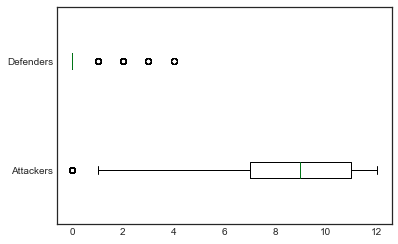

In [230]:
# box plot showing the same thing as the bar graph with a little bit less fidelity
plot_survivor_box(12,4)

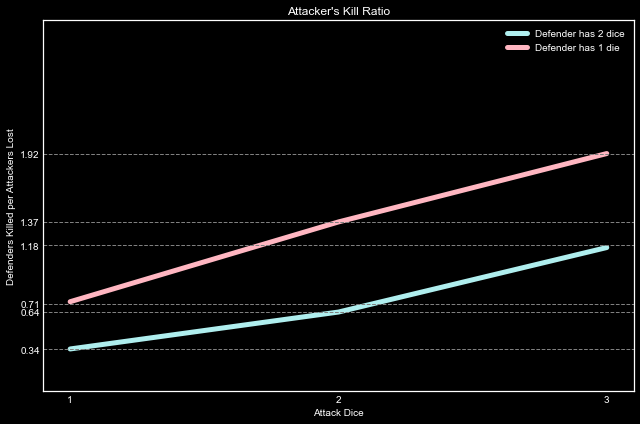

In [373]:
plot_a_kill_ratio()

In [ ]:
plot_d_kill_ratio()

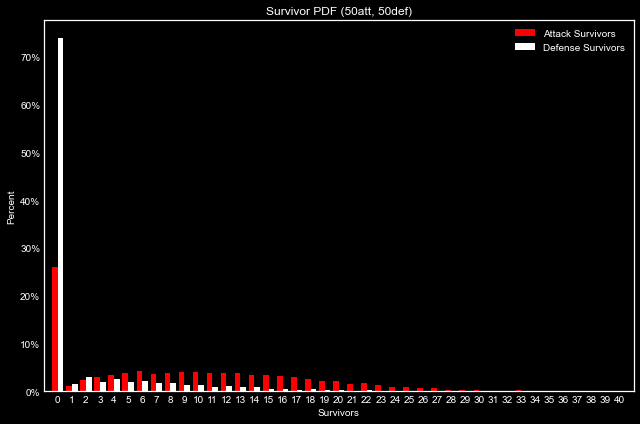

In [363]:
plot_survivor_pdf(50,50)

In [233]:
# graph references
# list(G.nodes) --- list of all nodes
# list(G.edges) --- list of tuples showing all edges
# list(G.adj[4]) --- lists adjacent nodes
# print(G.degree) --- dictionary with degree for each node
# G.add_node(1, time='4pm') --- for adding data
# [_ for _ in G.neighbors(3)] --- iterates over all the neighbors
# [G.nodes[num]['player'] for num in range(42)] --- lists values for all players *****